In [1]:
from scipy.io import loadmat


import mne
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv1D, 
                                     MaxPooling1D, GlobalAveragePooling1D)
from tensorflow.keras import utils

import itertools

#The below launches matplotlib so that each chart appears as a pop up window
#rather than in-line in the notebook. This is crucial for MNEs charts
#to work as designed and let you jump between channels and epochs
import matplotlib.pyplot as plt
%matplotlib qt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Info on the study I am trying to replicate and improve on
1. The full study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/
2. The data description (including data dictionary): https://lampx.tugraz.at/~bci/database/004-2015/description.pdf

### Investigating which Python EEG libraries to use
There are several Python libraries which are designed to help process EEG data. I'll investigate each.

- EEGLib
    - https://www.sciencedirect.com/science/article/pii/S2352711021000753
    - Primarily used for feature extraction after the data has been processed, but it does have some preprocessing capability
    - Appears to be written to allow visual inspection of data and then creation of features based on the selected point - certainly worth investigating
- MNE Python
    - https://mne.tools/dev/auto_tutorials/intro/10_overview.html
    - Appears to be the most popular python extension for EEG work
    - There is a hell of a lot going on here. Lots of transformations, etc. It seems to have very robust documentation, however, and I think it will work on my data
    - Comes with sample jupyter notebooks and a sample dataset to see the tools in action
    - Seems like I should definitely use MNE, and then I could consider doing EEGlib if I want to go above and beyond / see if I can get better features for modeling that way
- EEGLab
    - EEGlab is not a Python library - it is based on Matlab and also uses Octave. It appears to be the most popular tool for EEG analysis - however I assume Python's machine learning tools are much more powerful
    - It is possible to run some EEGlab commands in Python if I absolutely had to: https://eeglab.org/others/EEGLAB_and_python.html
    
I set up an mne environment (which does not currently include sci kit learn) to start to see if I can ingest this data. Would need to then open the converted data in my base environment to model it with sklearn, or alternatively pull sklearn into my mne environment.

**I installed MNE with core functionality only** per the instructions on this page: https://mne.tools/stable/install/manual_install.html

I tried to install the full package with 3D vizualizations as suggested via mamba, but got an error in the install.

### Loading data into MNE

First, we will use scipy to open the .mat file. Then, we need to prepare the data to be loaded into MNE. MNE requires both the array of data (with shape samples x channels) and an info file with the channel names, sample rate, channel types, and channel positions.

In the data documentation they listed the channel positions they used, but I cannot be sure they are listed in the documentation in the same order as the data is stored in the dataset.

For the purposes of building a model I don't need the channel positions. However, when I'm done with the model, it would be useful to be able to say which electrode positions would be necessary for a commercialized product based on these insights. As a result, I will assume that the electrodes are listed in the same order in the data as in the documentation, but I will need to sense-check my insights at the end (e.g., for the tasks focused on imagining motion of the hands and feet, the electrodes near the motor cortex should get the strongest signal. If that is not the case when I examine which electrodes are generating the signal at the end, then it is likely that the electrode data is not stored in the same order as listed in the documentation.

Here is the technique to use to read data into MNE from an array: https://mne.tools/0.16/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py

In [2]:
#use scipy loadmat to load .mat data in
annots = loadmat('data/A.mat')

In [3]:
annots.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [4]:
[data] = annots['data']

In [5]:
len(data)

2

In [6]:
[data_0] = data[0]
[data_1] = data[1]

I hypothesize at this point that data_0 and data_1 are the trial data for subject A on day 1 and day 2 respectively, they appear to be the same shape and have a lot of data in each.

In [7]:
df_0 = pd.DataFrame(data_0)

In [8]:
df_0

X  \
0  [[-4.640268558785382, -1.28023193713283, -3.15...   

                                                   y  \
0  [[4], [2], [1], [4], [3], [4], [5], [4], [3], ...   

                                               trial       fs  \
0  [[5121], [8517], [11911], [15175], [18588], [2...  [[256]]   

                                    classes session  
0  [[[WORD], [SUB], [NAV], [HAND], [FEET]]]   [[1]]

Confirmed - each of these highest-level arrays captures all the information from each of the two trials on this subject. - so data_1 has all this same information for the second session with this trial participant.

In [9]:
[X] = df_0['X']

In [10]:
X.shape

(714810, 30)

This is great news - the 30 channels for the 30 electrodes I was expecting are here. X is the raw data I'll feed into MNE.

**Now to construct the info file that will accompany the raw data into MNE**

Unfortunately the channel names (locations on the head on which the 30 electrodes were placed) are not recorded in this dataset. Per my comment above, I will assume the data is stored in the same order that the channels are listed in the documentation, and at the end of the project, I can sense check that assumption by looking at which channels recorded the strongest signal for the motor-cortex intensive tasks. In addition, channels AFz and CPz should not appear to activate strongly during any of the trials - those are the reference and ground electrodes placed on the left and right mastoid (behind the ear).

Even if the channels are incorrect, it won't impact my ability to answer the problems statement, because I can still construct a model which predicts yes/no - I just wouldn't be able to recommend where to place electrodes for a commercialized version of this study.

Here is the documenation on an mne info file: https://mne.tools/0.16/generated/mne.create_info.html#mne.create_info

In [11]:
ch_names = ['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 
            'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 
            'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2']
#per the documentation data was collected at 256 hertz
sfreq = 256
#all channel types are eeg sensors
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

### Loading this data for our first trial with our first participant into MNE

In [12]:
#transpose data to get it in correct shape
#This raw array is the simplest way to organize data in mne
subject_A_session_1_raw = mne.io.RawArray(X.T, info)

Creating RawArray with float64 data, n_channels=30, n_times=714810
    Range : 0 ... 714809 =      0.000 ...  2792.223 secs
Ready.


In [13]:
mne.pick_types(info=info, eeg=True, exclude=[])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [14]:
ch_names[0:5]

['AFz', 'F7', 'F3', 'Fz', 'F4']

In [15]:
#plotting the first 5 channels over the first 2 seconds
data, times = subject_A_session_1_raw[0:5, 0:500]

plt.plot(times, data.T, label=ch_names[0:5])
plt.xlabel('time (s)')
plt.ylabel('EEG data (T)')
plt.legend()

### Combining our raw data for subject A with when trials occurred using MNE epochs

To do this, we'll construct the events array as follows:
- 3 columns x number of trials in dataset
- First column is the sample # where the trial occurred - locates event in time in our data array
    - We'll need to transform this in our data. MNE looks for the event as the time at which the stimulus began, whereas in our dataset the timestamp we've been provided is when their trial started. The stimulus occured 3 seconds after the beginning of each trial in all cases.
- 2nd column is a 0 in our case - only used with analog signals
- 3rd column is the event ID, what kind of event this trial was testing

Based on this documentation:
https://mne.tools/0.16/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py
https://mne.tools/0.16/generated/mne.EpochsArray.html#mne.EpochsArray 
https://mne.tools/dev/auto_tutorials/intro/20_events_from_raw.html 
https://mne.tools/stable/glossary.html#term-events

In [16]:
[trials] = df_0['trial']
middle = np.array([[0 for num in range(200)]])
[event_ids] = df_0['y']

In [17]:
#Add 3 seconds (with 256Hz sample rate) to get stimulus times
event_times = np.array([[trial_time + (256 * 3) 
                         for trial_time in trials.flatten()]])

In [18]:
#Construct the events array
events = np.concatenate((event_times.T, middle.T, event_ids), axis=1)

In [19]:
events_dict = {'brainteaser/word': 1, 'brainteaser/subtraction': 2, 
               'brainteaser/navigation': 3, 'motor/hand': 4, 'motor/feet': 5}

In [20]:
subject_A_session_1_epoch_no_baseline = mne.Epochs(subject_A_session_1_raw, 
                                       events=events, 
                                       event_id=events_dict, 
                                       #subtract 3 seconds from event,
                                       #Add 7 seconds (less one sample),
                                       #To get their definition of trial
                                       tmin=-3, tmax=(7 - 1/256), 
                                       baseline=None)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [21]:
#Visualizing at all channels, 1 epoch at a time
subject_A_session_1_epoch_no_baseline.plot(scalings='auto', 
                                           n_epochs=1);

Using data from preloaded Raw for 200 events and 2560 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 162 events and 2560 original time points ...
Using matplotlib as 2D backend.
Opening epochs-browser...
Using data from preloaded Raw for 1 events and 2560 original time points ...


### Generating our data for loading into our neural networks
In general, the goal here is to get ready to load our data into neural networks. There are a number of different considerations for how we might want to load the data:
1. Creating the most accurate predictor possible
2. Commercializability of the result

Steps to get there:
1. Preprocess / slice the data in many different ways & see how the neural net performs on each. Each step notes whether this transformation needs to happen on raw data vs epoched data, as well as whether to be done on individual data or the entire dataset
    - **Raw data**
        - Double check that I'm interpreting their trial times correctly - make those charts showing the dotted line events vs the data to see if I'm off by 3 seconds or something like that
    - **Frequency filtered** (on raw data, should work across all datasets at once after combination)
        - High frequency filter (called low pass)
            - Try 40 and 50Hz
                - It sounds like this should be less necessary in EEG data than MEG data, because the ambient interference of AC power has much lower effect on EEG data
        - Low frequency filter (called high pass)
            - Try 0.01, 0.05, and 0.1 Hz filter, per the recommendation here: https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html#sphx-glr-auto-tutorials-preprocessing-25-background-filtering-py
        - I should try both FIR and IIR filtering (whether the filters only look forward in time from any given time or look backward in time as well). In general FIR is recommended, but IIR has some advantages too.
    - **Use signal-space projections (SSP) signal space separation(SSS) and independent component analysis (ICA) to programmatically remove artifacts** (can be done on raw or epoch data)
        - Read more here: https://www.frontiersin.org/articles/10.3389/fnins.2013.00267/full
        - Order of operations is filtering then SSP or ICA
        - De-prioritizing SSP for now due to limitations in using it on an ongoing basis in a BCI device. See notebook section on SSP below for fuller explanation. Circle back to this if approaches above don't yield good results.
    - **Baseline correction** (done in process of epoch creation)
        - Calculate the mean reading in the pre-stimulus period of each trial and then subtract that mean from the entire trial period to control for the state of mind at the time of each trial
        - Read more here: https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/BaselineCorrection.html
        - Is this useful in an ongoing basis if we were really building a device? Because the device won't know when the event is going to occur ahead of time. Talk this through with Sophie / Eric but I think I can skip this? Or maybe on an ongoing basis the software could guess when events are occuring with random sampling and do baseline analyses? Still seems potentially error prone.
    - **Resample data** at a few different levels (resampling automatically includes a high pass filter to ensure aliasing does not occur in downsampling) - applied to epoch objects:
        - Keep every 8th recording (Gamma waves in brain at 30Hz+, so should not decimate any more than this)
        - Keep every 4th recording
        - Keep every 2nd recording
        - I should decimate in the epoch rather than the raw data to avoid shifting the events and missing exact timings: https://mne.tools/0.22/overview/faq.html#what-are-all-these-options-for-resampling-decimating-and-binning-data
    - **Averaged data** - generally frowned upon in EEG signal processing it sounds like. Here is MNE tool, but sounds like better to just do on my own: https://mne.tools/0.22/generated/mne.SourceEstimate.html#mne.SourceEstimate.bin
        - Average each group of 32 recordings
        - Average each group of 8 recordings
        - Average each group of 4 recordings
        - Given that it is frowned upon, do this only if I can't get results any other way
    - **Using the filters they used in the original study**:
        1. Exclude the channels noted here for having artifacts: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/table/pone.0123727.t001/
            - Note that I think this is not good practice for a real device - you can't just throw out data you don't like
            - See how these channels look after various of the above transformations
        2. Use Common Spatial Pattern filters to transform the data - see this paper for full explanation: https://sci-hub.se/10.1109/MSP.2008.4408441
            - MNE has tools to do CSP, but it doesn't sounds generalizable, more of a manual process? Need to read more: https://mne.tools/stable/generated/mne.decoding.CSP.html
    - In all cases I need to normalize the data before modeling (do this after pulling the data for each modeling test out of the epoch object when all applicable filters, baseline corrections, etc have already been applied)
    - Should I try trimming max amplitudes before normalizing? E.g., normalize to 99th percentile or 95th or similar
    - Time permitting, I could also try fully transforming the data into the frequency domain and then modeling it. Would need to think about what segment of signal to transform into the frequency domain (likely only after the stimulus in that case?)
        - Could also just be interesting charts, although only helpful for solving the problem if useful in modeling
2. Try running each of those sets through a neural net to see which performs the best
3. Optimize the neural network on that selected preprocessing set
    1. How big should the image be that I pass to the neural net? E.g., how much before the stimulus and how long after it should the slice be that I feed in as input?
    2. If I need more data, I can get more unique no-stimulus segments to use by getting the time between trials, after them, the long tail at the end of trials, etc. Will require some clever code to slice it into the right shapes, but we can get there if I have time for that kind of optimization
    3. How many levels deep should the network be? Step size, filter size, etc.
    4. Is there a way to give more weight to the trials for a particular respondent? That way I could tune a custom model for each person while still getting the benefit of the 9X larger sample size from all the respondents
    5. Test each individual task as a binary classification to find my activation function
    6. Test each pair of tasks vs each other to find my yes/no function
4. Find the task that I can predict the best vs background noise (so only fires yes when that trial is really occuring)
    - How many seconds do I need of signal to generate that prediction?
        - To start with, I think send all 10 seconds for each trial if I can
        - Then could try to reduce that down - 10 seconds would be very frustrating to use in the real world
        - Can also inform how small I could make the testing period by visually inspecting the data
    - How many channels?
        - To answer this question, I think its best to first feed in all 30 channels of data and see which task I can predict best vs the entire rest of the dataset
5. Then have two different tasks which I can differentiate between the best (only data the model has to see now is the respective trial data)
    - Similarly to the above, how many channels are needed to make that differentiation
6. Because then I would collectively have described a simple BCI device that the patient could wear at all times and use to answer yes/no questions

### Loading full dataset in raw unaltered format

Here we'll ingest all the raw data from our all participants such that it can be manipulated programmatically as dictionaries going forward. Each dictionary will be named according to the kind of data within it, and every dictionary will have the same keys that correspond to experiment sessions.

E.g., the data_dict will include all the raw data (EEG samples). Within that dictionary, the key 'sub_A_sesh_1' will contain all the data from subject A session 1.

**Create function to ingest data**

In [22]:
#Create function to ingest subject data
#Returns session 1 data, session 1 trial times, session 1 task list per trial,
#Session 2 data, session 2 trial times, session 2 task list per trial
def data_ingester(filename):
    #open file in scipy
    annots = loadmat(filename)
    #dig into data to get to data for each session
    [data] = annots['data']
    [sesh_1] = data[0]
    [sesh_2] = data[1]
    #Creating dataframes of each sessions data
    sesh_1 = pd.DataFrame(sesh_1)
    sesh_2 = pd.DataFrame(sesh_2)

    #save eeg recording data from session 1
    [a] = sesh_1['X'] 
    #save the sample numbers at which each trial began in session 1
    [b] = sesh_1['trial']
    #save the list of what task was performed in each trial in session 1
    [c] = sesh_1['y']

    #save the raw eeg recording data from session 2
    [d] = sesh_2['X']
    #save the sample numbers at which each trial began in session 2
    [e] = sesh_2['trial']
    #save the list of what task was performed in each trial in session 2
    [f] = sesh_2['y']
    
    #return all needed data
    return a, b, c, d, e, f

In [23]:
#Create dictionaries to populate with our data
data_dict = {}
trial_times_dict = {}
y_dict = {}

In [24]:
#extract data for subject A
(data_dict['sub_A_sesh_1'], 
 trial_times_dict['sub_A_sesh_1'], 
 y_dict['sub_A_sesh_1'], 
 data_dict['sub_A_sesh_2'], 
 trial_times_dict['sub_A_sesh_2'], 
 y_dict['sub_A_sesh_2']) = data_ingester('data/A.mat')

In [25]:
#extract data for subject C
(data_dict['sub_C_sesh_1'], 
 trial_times_dict['sub_C_sesh_1'], 
 y_dict['sub_C_sesh_1'], 
 data_dict['sub_C_sesh_2'], 
 trial_times_dict['sub_C_sesh_2'], 
 y_dict['sub_C_sesh_2']) = data_ingester('data/C.mat')

In [26]:
#extract data for subject D
(data_dict['sub_D_sesh_1'], 
 trial_times_dict['sub_D_sesh_1'], 
 y_dict['sub_D_sesh_1'], 
 data_dict['sub_D_sesh_2'], 
 trial_times_dict['sub_D_sesh_2'], 
 y_dict['sub_D_sesh_2']) = data_ingester('data/D.mat')

In [27]:
#extract data for subject E
(data_dict['sub_E_sesh_1'], 
 trial_times_dict['sub_E_sesh_1'], 
 y_dict['sub_E_sesh_1'], 
 data_dict['sub_E_sesh_2'], 
 trial_times_dict['sub_E_sesh_2'], 
 y_dict['sub_E_sesh_2']) = data_ingester('data/E.mat')

In [28]:
#extract data for subject F
(data_dict['sub_F_sesh_1'], 
 trial_times_dict['sub_F_sesh_1'], 
 y_dict['sub_F_sesh_1'], 
 data_dict['sub_F_sesh_2'], 
 trial_times_dict['sub_F_sesh_2'], 
 y_dict['sub_F_sesh_2']) = data_ingester('data/F.mat')

In [29]:
#extract data for subject G
(data_dict['sub_G_sesh_1'], 
 trial_times_dict['sub_G_sesh_1'], 
 y_dict['sub_G_sesh_1'], 
 data_dict['sub_G_sesh_2'], 
 trial_times_dict['sub_G_sesh_2'], 
 y_dict['sub_G_sesh_2']) = data_ingester('data/G.mat')

In [30]:
#extract data for subject H
(data_dict['sub_H_sesh_1'], 
 trial_times_dict['sub_H_sesh_1'], 
 y_dict['sub_H_sesh_1'], 
 data_dict['sub_H_sesh_2'], 
 trial_times_dict['sub_H_sesh_2'], 
 y_dict['sub_H_sesh_2']) = data_ingester('data/H.mat')

In [31]:
#extract data for subject J
(data_dict['sub_J_sesh_1'], 
 trial_times_dict['sub_J_sesh_1'], 
 y_dict['sub_J_sesh_1'], 
 data_dict['sub_J_sesh_2'], 
 trial_times_dict['sub_J_sesh_2'], 
 y_dict['sub_J_sesh_2']) = data_ingester('data/J.mat')

In [32]:
#extract data for subject L
(data_dict['sub_L_sesh_1'], 
 trial_times_dict['sub_L_sesh_1'], 
 y_dict['sub_L_sesh_1'], 
 data_dict['sub_L_sesh_2'], 
 trial_times_dict['sub_L_sesh_2'], 
 y_dict['sub_L_sesh_2']) = data_ingester('data/L.mat')

**Constructing the info file that will be combined with our datasets to create an MNE raw object**

Unfortunately the channel names (locations on the head on which the 30 electrodes were placed) are not recorded in this dataset. I will assume the data is stored in the same order that the channels are listed in the documentation, and at the end of the project, I can sense check that assumption by looking at which channels recorded the strongest signal for the motor-cortex intensive tasks.

Even if the channels are incorrectly mapped, it won't impact my ability to answer the problem statement, because I can still construct a model which predicts yes/no - I just wouldn't be able to recommend where to place electrodes for a commercialized version of this study.

Here is the documentation on what goes into an mne info file: https://mne.tools/0.16/generated/mne.create_info.html#mne.create_info

Later on when converting the MNE raw object into an MNE epoch object, we'll need a dictionary as well to translate the event type numbers into the actual physical events.

In [33]:
#channels used from study documentation
ch_names = ['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 
            'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 
            'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2']
#per the study documentation data was collected at 256 hertz
sfreq = 256
#all channel types are eeg sensors
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

In [34]:
events_explained = {'brainteaser/word': 1, 'brainteaser/subtraction': 2, 
               'brainteaser/navigation': 3, 'motor/hand': 4, 'motor/feet': 5}

**Load each session's data into an MNE raw array** A number of our processing steps need to happen at the individual trial level - notably SSP/ICA/SSS modifications and standard scaling. For example, when looking at the primary components of the data (via SSP, ICA, or SSS) to correct for artifacts, it is unlikely the exact same artifacts occurred in every test. Similarly to standard scale the data that scaling needs to be done at the individual trial level (if one respondent had slightly higher amplitudes, we don't want that to downscale the data of other respondents).

Additionally, in a deployed BCI device, all transformations need to happen at the individual user level as well.

In [35]:
data_dict.keys()

dict_keys(['sub_A_sesh_1', 'sub_A_sesh_2', 'sub_C_sesh_1', 'sub_C_sesh_2', 'sub_D_sesh_1', 'sub_D_sesh_2', 'sub_E_sesh_1', 'sub_E_sesh_2', 'sub_F_sesh_1', 'sub_F_sesh_2', 'sub_G_sesh_1', 'sub_G_sesh_2', 'sub_H_sesh_1', 'sub_H_sesh_2', 'sub_J_sesh_1', 'sub_J_sesh_2', 'sub_L_sesh_1', 'sub_L_sesh_2'])

In [36]:
raw_dict = {}
for key, value in data_dict.items():
    raw_dict[key] = mne.io.RawArray(value.T, info)

Creating RawArray with float64 data, n_channels=30, n_times=714810
    Range : 0 ... 714809 =      0.000 ...  2792.223 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=714606
    Range : 0 ... 714605 =      0.000 ...  2791.426 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=713808
    Range : 0 ... 713807 =      0.000 ...  2788.309 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=714218
    Range : 0 ... 714217 =      0.000 ...  2789.910 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=714139
    Range : 0 ... 714138 =      0.000 ...  2789.602 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=714037
    Range : 0 ... 714036 =      0.000 ...  2789.203 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=714701
    Range : 0 ... 714700 =      0.000 ...  2791.797 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=618144
    Range : 0 ..

In [37]:
#event array combines stimulus times (3 sec after start of trial),
#A middle column of zeros since our data is digital,
#And a final column to indicate which kind of stimulus occurred
event_dict = {}
for key, value in trial_times_dict.items():
    event_dict[key] = np.concatenate((np.reshape(value.flatten() + (256 * 3), 
                                                 (len(value), 1)),
                                      np.zeros((y_dict[key].shape[0], 1)),
                                      y_dict[key]), axis=1).astype(int) 

### Preprocess the data prior to modeling

Setting up a pipeline to perform our transformations easily:
1. Filtering
2. Dropping channels
3. Baseline correction
4. Dropping artifacts via SSP (uses projectors_to_apply) variable, should be in the form slice(start, end, step)
5. Decimate data
6. Select sample length (how many seconds of data are we considering, and which seconds)
7. Amplitude based drop epochs? - To be able to do this I need to visualize a lot of data, not currently in place
8. Different standard scaler? - not currently in use

In [38]:
l_freq_filter = 0.1 #freq below this will be filtered out
h_freq_filter = 40 #freq above this will be filtered out
channels_to_drop = ['AFz'] #These channels will be removed from analysis
baseline_correction = (None, 0) #by epoch, time over which to take avg and subtract
projectors_to_apply = slice(2, 20, 4) #Which SSP projectors to apply
selected_frequency = 128 #Frequency to downselect to - should be factor of 256
tmin = 0 #starting time in seconds to take sample for modeling. 0 = stimulus
tmax = 4 #end time in seconds to take sample for modeling. 7 = end of epoch

In [39]:
l_freq_filter_options = [0.1, 1]
h_freq_filter_options = [40, 50]
channels_to_drop_options = [[], 
                            #['F7'], 
                            ['AFz', 'F7', 'F6'], 
                    #['AFz', 'F7', 'F6', 'T3', 'T4'], 
                    ['AFz', 'F7', 'F6', 'T3', 'T4', 'P7', 'PO3', 'O1', 'PO4', 
                     'P8', 'C4', 'P6']]
baseline_correction_options = [None, (None, 0)]
projectors_to_apply_options = [slice(1), slice(1, 2), slice(1, 5)]
selected_frequency_options = [256, 128, 64]
tmin_options = [0, 0.3]
tmax_options = [2, 4.5]

In [40]:
columns = ['l_freq_filter', 'h_freq_filter', 'channels_to_drop', 
           'baseline_correction', 'projectors_to_apply', 'selected_frequency', 
           'tmin', 'tmax']
#Create dataframe with all combinations of processings steps as rows
test_df = pd.DataFrame(itertools.product(l_freq_filter_options, 
                                         h_freq_filter_options, 
                                         channels_to_drop_options, 
                                         baseline_correction_options, 
                                         projectors_to_apply_options, 
                                         selected_frequency_options,
                                         tmin_options,
                                         tmax_options), 
                      columns=columns)

We are setting out to build the best binary classifier to be able to differentiate between two of the kinds of trials conducted in this study. To compare each of the five different kinds of trials against each other in pairwise combos, we need to create a list of those combinations.

In [41]:
#Create list of trial combinations we will test against each other
combo_list = list(itertools.product(list(range(1, 6)), repeat=2))
unique_combo_list = []
for combo in combo_list:
    if combo[0] != combo[1] and (combo[1], combo[0]) not in unique_combo_list:
        unique_combo_list.append(combo)

However, we need to shorten our processing time to finish our grid search on preprocessing - as it stands, with this set of preprocessing combos and checking every unique combination of trials against each other, it will take more than 48 hours to finish the grid search.

To shorten that time, we will look only at the top third of the combinations that performed best in my early trials (that outperformance was consistent across different permutations).

In [42]:
trial_combo_list = [(1, 5), (2, 4), (1, 3)]

In [43]:
#Add those combos to our test_df to save highest val accuracy achieved
test_df = test_df.reindex(columns=columns + 
                          [str(combo) for combo in trial_combo_list])

Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


### Now let's create the loop that will run through the entire set of combinations and generate our results

In [46]:
for row in range(test_df.shape[0]):
    #Filter data with bandpass. Note raw.filter applies in place
    for key, value in raw_dict.items():
        value.filter(l_freq=test_df.l_freq_filter[row], 
                     h_freq=test_df.h_freq_filter[row], 
                     method='fir', phase='zero', verbose=0)

    #Create epoch array with our raw objects and events arrays
    #Baseline (None, 0) finds the mean value of all samples before stimulus
    #Picks pulls all channels in the picks list into the epoch (rest are dropped)
    channels_to_keep = [ch for ch in ch_names if 
                        ch not in test_df.channels_to_drop[row]]
    epoch_dict = {}
    for key, value in raw_dict.items():
        epoch_dict[key] = mne.Epochs(value, events=event_dict[key], 
                                    event_id=events_explained, 
                                    #subtract 3 seconds from event,
                                    #Add 7 seconds (less one sample),
                                    #To get our study's definition of trial
                                    tmin=-3, tmax=(7 - 1/256), 
                                    baseline=test_df.baseline_correction[row],
                                    preload=True,
                                    picks=channels_to_keep, verbose=0)
        
    #Create dictionary of top 5 signal space projection vectors for each epoch
    proj_dict = {}
    for key, value in epoch_dict.items():
        proj_dict[key] = mne.compute_proj_epochs(value, n_eeg=5, verbose=0)
        
    #apply projectors
    for key, value in epoch_dict.items():
        value.add_proj(proj_dict[key][test_df.projectors_to_apply[row]], 
                       verbose=0)
        value.apply_proj(verbose=0)
        
    #Resample the data
    for key, value in epoch_dict.items():
        value.resample(sfreq=test_df.selected_frequency[row])
        
    #Standard scale data and extract the amount of time we want to model on
    mne_scaler = mne.decoding.Scaler(scalings='median')
    final_data_dict = {}
    for key, value in epoch_dict.items():
        final_data_dict[key] = (mne_scaler.
                                fit_transform(value.
                                              get_data(tmin=test_df.tmin[row], 
                                                       tmax=test_df.tmax[row])))
        
    #Create list of all trials in each session
    sesh_1_list = [sesh for sesh in list(data_dict.keys()) if 'sesh_1' in sesh]
    sesh_2_list = [sesh for sesh in list(data_dict.keys()) if 'sesh_2' in sesh]
    
    #Concatenate data from all trials together by session
    sesh_1_data = np.concatenate(([final_data_dict[key] for 
                                   key in sesh_1_list]), axis=0)
    sesh_2_data = np.concatenate(([final_data_dict[key] for 
                                   key in sesh_2_list]), axis=0)
    
    #Get corresponding list of trials performed combined by session
    sesh_1_y = np.concatenate(([y_dict[key] for key in sesh_1_list]))
    sesh_2_y = np.concatenate(([y_dict[key] for key in sesh_2_list]))
    
    #reshape data tensor to be loaded into neural network
    sesh_1_data = np.reshape(sesh_1_data, (sesh_1_data.shape[0],
                                           sesh_1_data.shape[2],
                                           sesh_1_data.shape[1]))
    sesh_2_data = np.reshape(sesh_2_data, (sesh_2_data.shape[0],
                                           sesh_2_data.shape[2],
                                           sesh_2_data.shape[1]))
    
    #reshape ys to one dimension
    sesh_1_y = np.reshape(sesh_1_y, sesh_1_y.shape[0])
    sesh_2_y = np.reshape(sesh_2_y, sesh_2_y.shape[0])
    
    #Assemble combinations of ys for each pairwise comparison between trials
    #In each combo, coding 1st trial type to 0, 2nd trial type to 1
    sesh_1_y_combo_dict = {}
    for combo in trial_combo_list:
        trial_list_temp = []
        for y in sesh_1_y:
            if y == combo[0]:
                trial_list_temp.append(0)
            if y == combo[1]:
                trial_list_temp.append(1)
        sesh_1_y_combo_dict[combo] = np.array(trial_list_temp)
    #Repeated for session 2
    sesh_2_y_combo_dict = {}
    for combo in trial_combo_list:
        trial_list_temp = []
        for y in sesh_2_y:
            if y == combo[0]:
                trial_list_temp.append(0)
            if y == combo[1]:
                trial_list_temp.append(1)
        sesh_2_y_combo_dict[combo] = np.array(trial_list_temp)
        
    #Create combo dict of data for each relevant combination of trials
    sesh_1_data_combo_dict = {}
    for combo in trial_combo_list:
        index_list = []
        for i, y in enumerate(sesh_1_y):
            if y == combo[0] or y == combo[1]:
                index_list.append(i)
        sesh_1_data_combo_dict[combo] = sesh_1_data[index_list]
    #Repeat for session 2
    sesh_2_data_combo_dict = {}
    for combo in trial_combo_list:
        index_list = []
        for i, y in enumerate(sesh_2_y):
            if y == combo[0] or y == combo[1]:
                index_list.append(i)
        sesh_2_data_combo_dict[combo] = sesh_2_data[index_list]
       
    
    
    #Create model to predict all combinations of trial types
    for combo in trial_combo_list:
        #Build the model
        model = Sequential()
        model.add(Conv1D(40, 6, strides=2, padding='same', activation='relu', 
                     input_shape=(sesh_1_data_combo_dict[combo].shape[1], 
                                  sesh_1_data_combo_dict[combo].shape[2])))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(40, 4, strides=1, padding='same', activation='relu'))
#         model.add(Dropout(0.2))
#         model.add(MaxPooling1D(2))
#         model.add(Conv1D(40, 3, strides=1, padding='same', activation='relu'))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(2))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

        #Fit the model
        history = model.fit(sesh_1_data_combo_dict[combo], 
                            sesh_1_y_combo_dict[combo], 
                            batch_size=60, epochs=8, 
                            validation_data=(sesh_2_data_combo_dict[combo], 
                                             sesh_2_y_combo_dict[combo]), 
                            verbose=0, workers=8)

        #Save the best training and validation accuracy achieved by each model
        test_df.loc[[row], [str(combo)]] = max(history.history['val_accuracy'])
    test_df.to_csv('data/preprocessing_grid_search.csv', index=False)

After reviewing the first set of results, some clear patterns emerge:

- Every one of the top performing trials had the 1st projector removed
    - Should do more trials that include the 1st projector and additional projectors along with it
- No high performing trials at 64 Hertz
    - Don't test that slow a frequency on future tests
    - You'd think 256 v 128 would make a difference because I didn't change the number of samples the model was ingesting in its filter. Strange that it doesn't - data may just be too noisy still
- Baseline correction does not seem to matter either way
- No consensus on frequency filtering - potentially worth trying a narrower passband
- Dropping channels seems generally helpful, but no clear consensus between our two options which included dropping
    - Should add a new intermediate option with more than 3 but less than 12 channels dropped
- Very clear that a tmax of 2 is too low, all high performing trials at 4.5 seconds
    - tmin of 0.3 seems to slightly outperform 0.0
    - Should try some additional sampling to create more datapoints in trial set - for instance take from 0.3 to 4.5 and 0.0 to 4.2 to double the size of the trial dataset and give the model more to learn on
- Need to add dropping of bad epochs - its clear, particularly from the lack of difference between 128 and 256Hz sampling, that there is still too much noise in the data

**Let's add a new set of options to the test dataframe based on what we've learned**

Note both of these channels to drop options are new, so all of these are unique combinations compared to what we've tested before, meaning we can just add these new rows onto the bottom of our dataframe and then run the tests on the rows with NaNs in the output columns.

In [73]:
#Create new preprocessing combinations
l_freq_filter_options_2 = [0.1, 2]
h_freq_filter_options_2 = [35, 40]
channels_to_drop_options_2 = [['F7'], 
                    ['AFz', 'F7', 'F6', 'T3', 'T4']]
baseline_correction_options_2 = [None]
projectors_to_apply_options_2 = [slice(1), slice(0, 2), slice(0, 5)]
selected_frequency_options_2 = [256]
tmin_options_2 = [0.3]
tmax_options_2 = [3, 4.5]

In [78]:
#Add new rows of combinations to our test dataframe
test_df = pd.concat((test_df, pd.DataFrame(itertools.product(l_freq_filter_options_2, 
                                            h_freq_filter_options_2, 
                                            channels_to_drop_options_2, 
                                            baseline_correction_options_2, 
                                            projectors_to_apply_options_2, 
                                            selected_frequency_options_2,
                                            tmin_options_2,
                                            tmax_options_2), 
                                            columns=columns)),
                      ignore_index=True)

l_freq_filter  h_freq_filter       channels_to_drop baseline_correction  \
0              0.1             40                     []                None   
1              0.1             40                     []                None   
2              0.1             40                     []                None   
3              0.1             40                     []                None   
4              0.1             40                     []                None   
..             ...            ...                    ...                 ...   
907            2.0             40  [AFz, F7, F6, T3, T4]                None   
908            2.0             40  [AFz, F7, F6, T3, T4]                None   
909            2.0             40  [AFz, F7, F6, T3, T4]                None   
910            2.0             40  [AFz, F7, F6, T3, T4]                None   
911            2.0             40  [AFz, F7, F6, T3, T4]                None   

      projectors_to_apply  selected_frequency  tmin  tmax    (1, 5)    (2, 4)  \
0    slice(None, 1, None)                 256   0.0   2.0  0.524286  0.522857   
1    slice(None, 1, None)                 256   0.0   4.5  0.567143  0.588571   
2    slice(None, 1, None)                 256   0.3   2.0  0.521429  0.530000   
3    slice(None, 1, None)                 256   0.3   4.5  0.571429  0.572857   
4    slice(None, 1, None)                 128   0.0   2.0  0.540000  0.518571   
..                    ...                 ...   ...   ...       ...       ...   
907  slice(None, 1, None)                 256   0.3   4.5       NaN       NaN   
908     slice(0, 2, None)                 256   0.3   3.0       NaN       NaN   
909     slice(0, 2, None)                 256   0.3   4.5       NaN       NaN   
910     slice(0, 5, None)                 256   0.3   3.0       NaN       NaN   
911     slice(0, 5, None)                 256   0.3   4.5       NaN       NaN   

       (1, 3)  
0    0.508571  
1    0.572857  
2    0.510000  
3    0.561429  
4    0.504286  
..        ...  
907       NaN  
908       NaN  
909       NaN  
910       NaN  
911       NaN  

[912 rows x 11 columns]

In [79]:
test_df.shape

(864, 11)

In [72]:
test_df.sort_values(by='(1, 5)', ascending=False).head(40)

l_freq_filter  h_freq_filter  \
147            0.1             40   
619            1.0             40   
403            0.1             50   
73             0.1             40   
439            1.0             40   
181            0.1             40   
361            0.1             50   
583            1.0             40   
145            0.1             40   
365            0.1             50   
42             0.1             40   
39             0.1             40   
253            0.1             50   
255            0.1             50   
291            0.1             50   
691            1.0             50   
475            1.0             40   
721            1.0             50   
219            0.1             50   
690            1.0             50   
831            1.0             50   
109            0.1             40   
543            1.0             40   
367            0.1             50   
295            0.1             50   
111            0.1             40   
577            1.0             40   
337            0.1             50   
43             0.1             40   
649            1.0             50   
329            0.1             50   
3              0.1             40   
259            0.1             50   
37             0.1             40   
195            0.1             40   
183            0.1             40   
229            0.1             50   
615            1.0             40   
197            0.1             40   
289            0.1             50   

                                      channels_to_drop baseline_correction  \
147  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
619  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
403  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
73                                       [AFz, F7, F6]                None   
439                                                 []                None   
181  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
361  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
583  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
145  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
365  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
42                                                  []           (None, 0)   
39                                                  []           (None, 0)   
253                                                 []           (None, 0)   
255                                                 []           (None, 0)   
291                                      [AFz, F7, F6]                None   
691                                                 []           (None, 0)   
475                                                 []           (None, 0)   
721                                      [AFz, F7, F6]                None   
219                                                 []                None   
690                                                 []           (None, 0)   
831  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
109                                      [AFz, F7, F6]           (None, 0)   
543                                      [AFz, F7, F6]           (None, 0)   
367  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
295                                      [AFz, F7, F6]                None   
111                                      [AFz, F7, F6]           (None, 0)   
577  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
337                                      [AFz, F7, F6]           (None, 0)   
43                                                  []           (None, 0)   
649                                                 []                None   
329                                      [AFz, F7, F6]           (Non

In [51]:
test_df['(2, 4)'].max()

0.5899999737739563

In [52]:
test_df['(1, 3)'].max()

0.6028571724891663

# Below here is the loop to generate results in separate blocks

**First, filtering**

In [ ]:
#Filter data, bandpass from 0.1 to 40Hz. Note raw.filter applies in place
for key, value in raw_dict.items():
    value.filter(l_freq=l_freq_filter, h_freq=h_freq_filter, 
                 method='fir', phase='zero')

**Now apply baseline correction and drop bad channels**

Baseline correction is done in the process of creating an MNE epoch object, and resampling is applied to epoch objects.

To convert our raw arrays into an epoch object we'll need to create event arrays which hold the data for when each stimulus occurred and what the stimulus was.

In [ ]:
#event array combines stimulus times (3 seconds after start of trial per study documentation)
#A middle column of zeros since our data is digital
#And a final column to indicate which kind of stimulus occurred
event_dict = {}
for key, value in trial_times_dict.items():
    event_dict[key] = np.concatenate((np.reshape(value.flatten() + (256 * 3), 
                                                 (len(value), 1)),
                                      np.zeros((y_dict[key].shape[0], 1)),
                                      y_dict[key]), axis=1).astype(int)

Baseline correction finds the mean reading for a sample of time and then subtracts that mean from the data in the entire epoch. The first number in the tuple is the time in seconds (within the epoch) to start taking that mean (or if None the beginning of the epoch), and the second number in the tuple is the final time in seconds to include in that baseline mean. Note that the stimulus time is equal to 0. Then that computed mean is subtracted from every sample in the epoch.

In [ ]:
channels_to_keep = [ch for ch in ch_names if ch not in channels_to_drop]

In [ ]:
#Create epoch array with our raw objects and events arrays
#Baseline (None, 0) finds the mean value of all samples before stimulus
#Picks pulls all channels in the picks list into the epoch (rest are dropped)
epoch_dict = {}
for key, value in raw_dict.items():
    epoch_dict[key] = mne.Epochs(value, events=event_dict[key], 
                                event_id=events_explained, 
                                #subtract 3 seconds from event,
                                #Add 7 seconds (less one sample),
                                #To get our study's definition of trial
                                tmin=-3, tmax=(7 - 1/256), 
                                baseline=baseline_correction,
                                preload=True,
                                picks=channels_to_keep, verbose=0)

**Calculate and remove SSP from the data to remove artifacts**
Signal space projectors can be thought of as an equivalent for principal component analysis in other data formats. Essentially we will calculate the 'projections' running through each epoch and remove those that are creating noise in the data.

In [ ]:
#Create dictionary of top 5 signal space projection vectors for each epoch
proj_dict = {}
for key, value in epoch_dict.items():
    proj_dict[key] = mne.compute_proj_epochs(value, n_eeg=5)

In [ ]:
#apply projectors
for key, value in epoch_dict.items():
    value.add_proj(proj_dict[key][projectors_to_apply], verbose=0)
    value.apply_proj(verbose=0)

**Resample the data**
We're using resampling here, which automatically applies a high pass filter to avoid aliasing. Doing so will introduce some distortions at the beginning and end of each epoch, so we shouldn't use data from the very beginning and end of each of those 10 second periods.

In [ ]:
#Resampling to 128 Hz is every other sample in original 256 Hz dataset
for key, value in epoch_dict.items():
    value.resample(sfreq=selected_frequency)

### Now let's set our data up to model against it

This is a three step process:
1. Standardize our data. We will use sci kit learn's robust scaler, which is more robust to outliers
2. Extract the data from each epoch **and decide what amount of time to feed into model**
    - Stimulus was presented 3 seconds into each trial and was on screen for 1.25 seconds
3. Concatenate all data for sessions 1s (which we'll use as our training data) and session 2s (which will be our test data)
4. Reshape our arrays to match CNN requirements

In [ ]:
#setting scalings=median uses sklearn.preprocessing.RobustScaler
#Uses a median and interquartile range methodology that should be more
#robust to outliers
mne_scaler = mne.decoding.Scaler(scalings='median')
final_data_dict = {}
for key, value in epoch_dict.items():
#Taking from 3 to 9 seconds - stimulus and following 6 seconds
    final_data_dict[key] = mne_scaler.fit_transform(value.get_data(tmin=tmin,
                                                                   tmax=tmax))

In [ ]:
#Create list of all trials in each session
sesh_1_list = [sesh for sesh in list(data_dict.keys()) if 'sesh_1' in sesh]
sesh_2_list = [sesh for sesh in list(data_dict.keys()) if 'sesh_2' in sesh]

In [ ]:
#Concatenate data from all trials together by session
sesh_1_data = np.concatenate(([final_data_dict[key] for key in sesh_1_list]), 
                             axis=0)
sesh_2_data = np.concatenate(([final_data_dict[key] for key in sesh_2_list]), 
                             axis=0)

In [ ]:
#Get corresponding list of trials performed combined by session
sesh_1_y = np.concatenate(([y_dict[key] for key in sesh_1_list]))
sesh_2_y = np.concatenate(([y_dict[key] for key in sesh_2_list]))

In [ ]:
#reshape data tensor to be loaded into neural network
sesh_1_data = np.reshape(sesh_1_data, (sesh_1_data.shape[0],
                                       sesh_1_data.shape[2],
                                       sesh_1_data.shape[1]))
sesh_2_data = np.reshape(sesh_2_data, (sesh_2_data.shape[0],
                                       sesh_2_data.shape[2],
                                       sesh_2_data.shape[1]))

In [ ]:
#reshape ys to one dimension
sesh_1_y = np.reshape(sesh_1_y, sesh_1_y.shape[0])
sesh_2_y = np.reshape(sesh_2_y, sesh_2_y.shape[0])

In [ ]:
#Can potentially delete this, not likely to be doing categorical model again
#convert y to categorical and first shift range of 1-5 to 0-4
sesh_1_y_categorical = utils.to_categorical(sesh_1_y - 1)
sesh_2_y_categorical = utils.to_categorical(sesh_2_y - 1)

### Create pairwise combinations of trial types

The original study was done as a binary classifer, comparing each kind of trial type to each other in pairwise combinations. We need to set up our data in the same way and test our preprocessing steps against models running on those pairwise combinations of trials.

In [ ]:
#Create list of unique combinations of trial types we want to compare against
combo_list = list(itertools.product(np.unique(sesh_1_y), np.unique(sesh_1_y)))
trial_combo_list = []
for combo in combo_list:
    if combo[0] != combo[1] and (combo[1], combo[0]) not in unique_combo_list:
        trial_combo_list.append(combo)

In [ ]:
#Create y containing only relevant trials for each combination of trial types
#In each combo, coding 1st trial type to 0, 2nd trial type to 1
sesh_1_y_combo_dict = {}
for combo in trial_combo_list:
    trial_list_temp = []
    for y in sesh_1_y:
        if y == combo[0]:
            trial_list_temp.append(0)
        if y == combo[1]:
            trial_list_temp.append(1)
    sesh_1_y_combo_dict[combo] = np.array(trial_list_temp)
    
#Repeated for session 2
sesh_2_y_combo_dict = {}
for combo in trial_combo_list:
    trial_list_temp = []
    for y in sesh_2_y:
        if y == combo[0]:
            trial_list_temp.append(0)
        if y == combo[1]:
            trial_list_temp.append(1)
    sesh_2_y_combo_dict[combo] = np.array(trial_list_temp)

In [ ]:
#Create combo dict of data for each relevant combination of trials
sesh_1_data_combo_dict = {}
for combo in trial_combo_list:
    index_list = []
    for i, y in enumerate(sesh_1_y):
        if y == combo[0] or y == combo[1]:
            index_list.append(i)
    sesh_1_data_combo_dict[combo] = sesh_1_data[index_list]
    
#Repeat for session 2
sesh_2_data_combo_dict = {}
for combo in trial_combo_list:
    index_list = []
    for i, y in enumerate(sesh_2_y):
        if y == combo[0] or y == combo[1]:
            index_list.append(i)
    sesh_2_data_combo_dict[combo] = sesh_2_data[index_list]

**Build the model** Built very closely on https://justlv.medium.com/using-ai-to-read-your-thoughts-with-keras-and-an-eeg-sensor-167ace32e84a

In [ ]:
#Loop through all combinations of trial types
for combo in trial_combo_list:
    #Build the model
    model = Sequential()
    model.add(Conv1D(40, 6, strides=2, padding='same', activation='relu', 
                 input_shape=(sesh_1_data_combo_dict[combo].shape[1], 
                              sesh_1_data_combo_dict[combo].shape[2])))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(40, 4, strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(40, 3, strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    #Fit the model
    print(f'Current trial combo {combo} being modeled')
    history = model.fit(sesh_1_data_combo_dict[combo], 
                        sesh_1_y_combo_dict[combo], 
                        batch_size=60, epochs=20, 
                        validation_data=(sesh_2_data_combo_dict[combo], 
                                         sesh_2_y_combo_dict[combo]), 
                        verbose=0)
    
    #Create charts showing the loss and accuracy for this model
    #put matplotlib inline to see results directly in notebook
    %matplotlib inline
    
    #First train loss and test loss over epochs
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epoch_labels = history.epoch
    plt.figure(figsize=(12, 8))
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')
    plt.title(f'Trial combo {combo} Training and Testing Loss by Epoch', 
              fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Binary Crossentropy', fontsize=18)
    plt.xticks(epoch_labels, epoch_labels)    # ticks, labels
    plt.legend(fontsize=18)
    plt.show()
    
    # Now chart training and validation accuracy over epochs
    train_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
    plt.plot(test_accuracy, label='Testing Accuracy', color='orange')
    plt.title(f'Trial combo {combo} Training and Testing Accuracy by Epoch', 
              fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Binary Crossentropy', fontsize=18)
    plt.xticks(epoch_labels, epoch_labels)    # ticks, labels
    plt.legend(fontsize=18)
    plt.show()

In [ ]:
# Check out our train loss and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
# Check out our train accuracy and test accuracy over epochs
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

# Below here section of work where I concatenated all data too early. Don't delete yet for reusing bits of code, but in general needs to be replaced

**Concatenate data for session 1**
In general, the approach here is to concatenate the data, trial times, and list of ys into a single list. To make the trial times work, I'll need to add the sum of all previously concatenated sessions total samples to each trial time before concatenating those trial times (to ensure those trial times line up with the new combined list of data readings).

In [ ]:
#get list of session 1 data samples to use in concatenation
data_list_sesh_1 = [sub_A_sesh_1_data, sub_C_sesh_1_data, sub_D_sesh_1_data,
                    sub_E_sesh_1_data, sub_F_sesh_1_data, sub_G_sesh_1_data, 
                    sub_H_sesh_1_data, sub_J_sesh_1_data, sub_L_sesh_1_data]

#Get number of samples in each subjects data
length_of_session_recordings = []
for dataset in data_list_sesh_1:
    length_of_session_recordings.append(dataset.shape[0])

In [ ]:
num_to_add_to_trial_times = []
for i, recording in enumerate(length_of_session_recordings):
    #No adjustment needed for first dataset
    if i == 0:
        num_to_add_to_trial_times.append(0)
    #add len of all previous datasets
    else:
        num_to_add_to_trial_times.append(sum(length_of_session_recordings[:i]))

In [ ]:
trial_times_sesh_1 = [sub_A_sesh_1_trial_times, sub_C_sesh_1_trial_times, 
                      sub_D_sesh_1_trial_times, sub_E_sesh_1_trial_times, 
                      sub_F_sesh_1_trial_times, sub_G_sesh_1_trial_times, 
                      sub_H_sesh_1_trial_times, sub_J_sesh_1_trial_times, 
                      sub_L_sesh_1_trial_times]

#Add length of all previous sessions to each set of trial times
for num, trial_time_array in zip(num_to_add_to_trial_times, 
                                 trial_times_sesh_1):
    trial_time_array += num

In [ ]:
#Creating all needed concatenated arrays for session 1
sesh_1_combined_data = np.concatenate(data_list_sesh_1, axis=0)
sesh_1_combined_trial_times = np.concatenate(trial_times_sesh_1)
#y doesn't need adjusting b/c simple list of trial types
sesh_1_combined_y = np.concatenate((sub_A_sesh_1_y, sub_C_sesh_1_y, 
                                    sub_D_sesh_1_y, sub_E_sesh_1_y, 
                                    sub_F_sesh_1_y, sub_G_sesh_1_y, 
                                    sub_H_sesh_1_y, sub_J_sesh_1_y, 
                                    sub_L_sesh_1_y))

**Concatenate data for session 2** Same process as above

In [ ]:
#get list of session 2 data samples to use in concatenation
data_list_sesh_2 = [sub_A_sesh_2_data, sub_C_sesh_2_data, sub_D_sesh_2_data,
                    sub_E_sesh_2_data, sub_F_sesh_2_data, sub_G_sesh_2_data, 
                    sub_H_sesh_2_data, sub_J_sesh_2_data, sub_L_sesh_2_data]

length_of_session_recordings = []
for dataset in data_list_sesh_2:
    length_of_session_recordings.append(dataset.shape[0])

In [ ]:
num_to_add_to_trial_times = []
for i, recording in enumerate(length_of_session_recordings):
    #No adjustment needed for first dataset
    if i == 0:
        num_to_add_to_trial_times.append(0)
    #add len of all previous datasets
    else:
        num_to_add_to_trial_times.append(sum(length_of_session_recordings[:i]))

In [ ]:
trial_times_sesh_2 = [sub_A_sesh_2_trial_times, sub_C_sesh_2_trial_times, 
                      sub_D_sesh_2_trial_times, sub_E_sesh_2_trial_times, 
                      sub_F_sesh_2_trial_times, sub_G_sesh_2_trial_times, 
                      sub_H_sesh_2_trial_times, sub_J_sesh_2_trial_times, 
                      sub_L_sesh_2_trial_times]

#Add length of all previous sessions to each set of trial times
for num, trial_time_array in zip(num_to_add_to_trial_times, 
                                 trial_times_sesh_2):
    trial_time_array += num

In [ ]:
#Creating all needed concatenated arrays for session 2
sesh_2_combined_data = np.concatenate(data_list_sesh_2, axis=0)
sesh_2_combined_trial_times = np.concatenate(trial_times_sesh_2)
#y doesn't need adjusting b/c simple list of trial types
sesh_2_combined_y = np.concatenate((sub_A_sesh_2_y, sub_C_sesh_2_y, 
                                    sub_D_sesh_2_y, sub_E_sesh_2_y, 
                                    sub_F_sesh_2_y, sub_G_sesh_2_y, 
                                    sub_H_sesh_2_y, sub_J_sesh_2_y, 
                                    sub_L_sesh_2_y))

Note: Subject E and Subject H only have 175 trials recorded in session 2 (instead of the usual 200) so session 2 has a total of 1750 trials instead of the 1800 in session 1.

**Translate trial times and y into MNE events array** In order to load our data into MNE as an epoch object, we need to format our trial times and event IDs in MNEs format.

In our dataset our trial times are defined as the beginning of a 10 second trial, 3 seconds into which the stimulus was presented to the subject. So we need to add 3 seconds (times 256 samples per second) to our trial times to put the data in the format MNE is expecting (oriented around event times).

In [ ]:
#Add 3 seconds (with 256Hz sample rate) to get stimulus times
sesh_1_event_times = np.array([[trial_time + (256 * 3) for trial_time 
                                in sesh_1_combined_trial_times.flatten()]]).T

#middle is all 0s because our signal is digital
middle = np.array([[0 for num in range(sesh_1_combined_y.shape[0])]]).T
#Construct MNEs events array
sesh_1_events = np.concatenate((sesh_1_event_times, middle, 
                                sesh_1_combined_y), axis=1)

In [ ]:
#Add 3 seconds (with 256Hz sample rate) to get stimulus times
sesh_2_event_times = np.array([[trial_time + (256 * 3) for trial_time 
                                in sesh_2_combined_trial_times.flatten()]]).T

#middle is all 0s because our signal is digital
middle = np.array([[0 for num in range(sesh_2_combined_y.shape[0])]]).T
#Construct MNEs events array
sesh_2_events = np.concatenate((sesh_2_event_times, middle, 
                                sesh_2_combined_y), axis=1)

### Creating raw arrays for session 1 and 2

In [ ]:
sesh_1_raw = mne.io.RawArray(sesh_1_combined_data.T, info)

In [ ]:
sesh_2_raw = mne.io.RawArray(sesh_2_combined_data.T, info)

### Filtering our raw data
Let's do all those filters we laid out earlier. Here are the helpful pages to make that happen:


https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#tut-filter-resample
https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html#sphx-glr-auto-tutorials-preprocessing-25-background-filtering-py
https://mne.tools/stable/generated/mne.filter.filter_data.html#examples-using-mne-filter-filter-data
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

Here are the filters we want to achieve:
   - Low frequency filter (called high pass)
        - Try 0.01, 0.1, 1, and 2 Hz filter. Best practice says 0.1 Hz is an ideal max for the high pass filter, but let's do a wider range and see how the models differentiate between them. See recommendations here: https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html#sphx-glr-auto-tutorials-preprocessing-25-background-filtering-py
   - High frequency filter (called low pass)
       - Try 40 and 50Hz
            - It sounds like this should be less necessary in EEG data than MEG data, because the ambient interference of AC power has much lower effect on EEG data
   - I should try both FIR and IIR filtering (whether the filters only look forward in time from any given time or look backward in time as well). In general FIR is recommended, but IIR has some advantages too.
    
**Note** MNE's auto scaler doesn't handle this dataset well. It appears the study authors may have scaled the data into different units than MNE was expecting before saving the data down. In any case, after trial and error, setting scalings to 30 seems to perform relatively well.

First, let's look at our high pass filter - how do these appear to be affecting the data?

In [ ]:
fig = sesh_1_raw.plot(duration=60, proj=False, n_channels=5,
                      remove_dc=False, scalings=30)
fig.subplots_adjust(top=0.9)
fig.suptitle('Raw, unfiltered data', weight='bold', size='xx-large')

In [ ]:
for cutoff in (0.01, 0.1, 1, 2):
    raw_highpass = sesh_1_raw.copy().filter(l_freq=cutoff, h_freq=None)
    with mne.viz.use_browser_backend('matplotlib'):
        fig = raw_highpass.plot(duration=60, proj=False,
                                n_channels=5, 
                                remove_dc=False, scalings=30)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Here are comparative views so we can see those filters in action. Note that because of the larger transition bandwidth and the frequency is reduced, the longer wavelength filters are filtering a smaller and smaller portion of this 1 minute view. 

- The 0.01 Hz filter is applied to the whole minute
- The 0.1 Hz filter is applied to the first 30 seconds
- The 1 Hz filter is applied to the first 3 seconds
- The 2 Hz filter is applied to the first 1.6 seconds 

Looking at these charts side by side the changes are hard to see, but laid directly over each other it is clear that all the filters are making changes. I will plan to apply all these filters and see how the neural network performs on each resulting set of data.

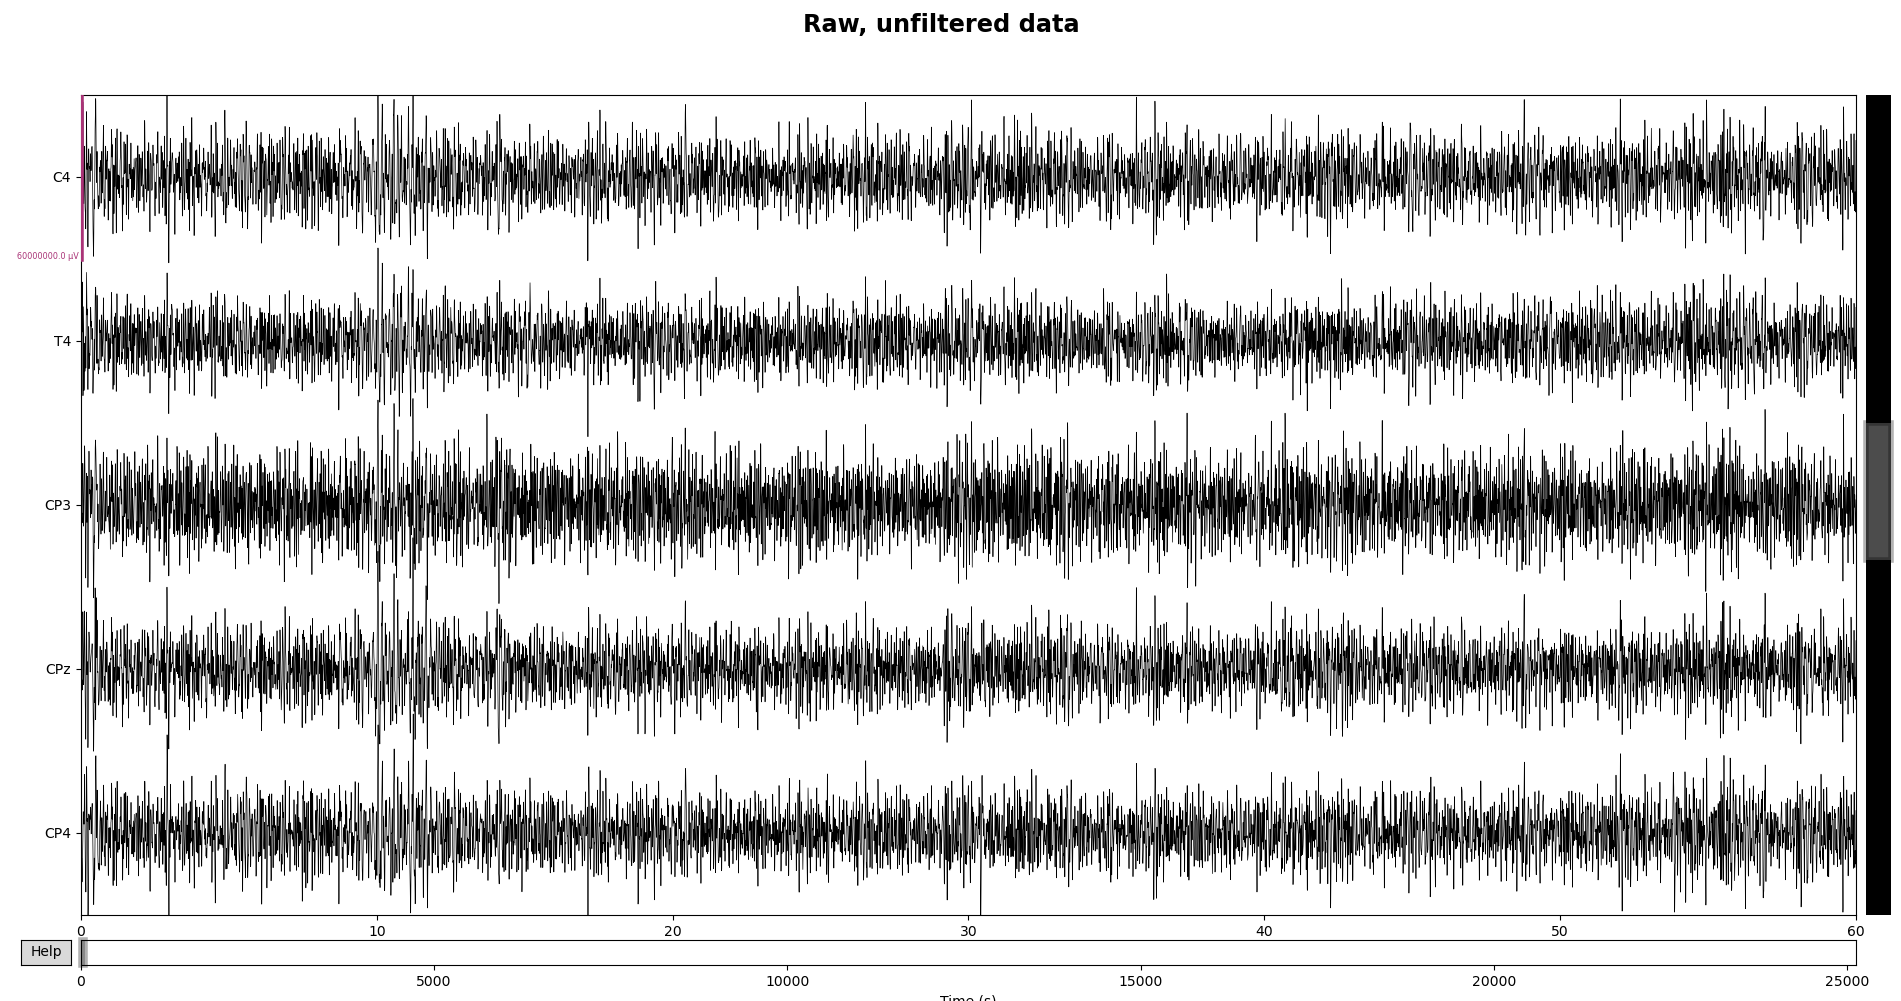

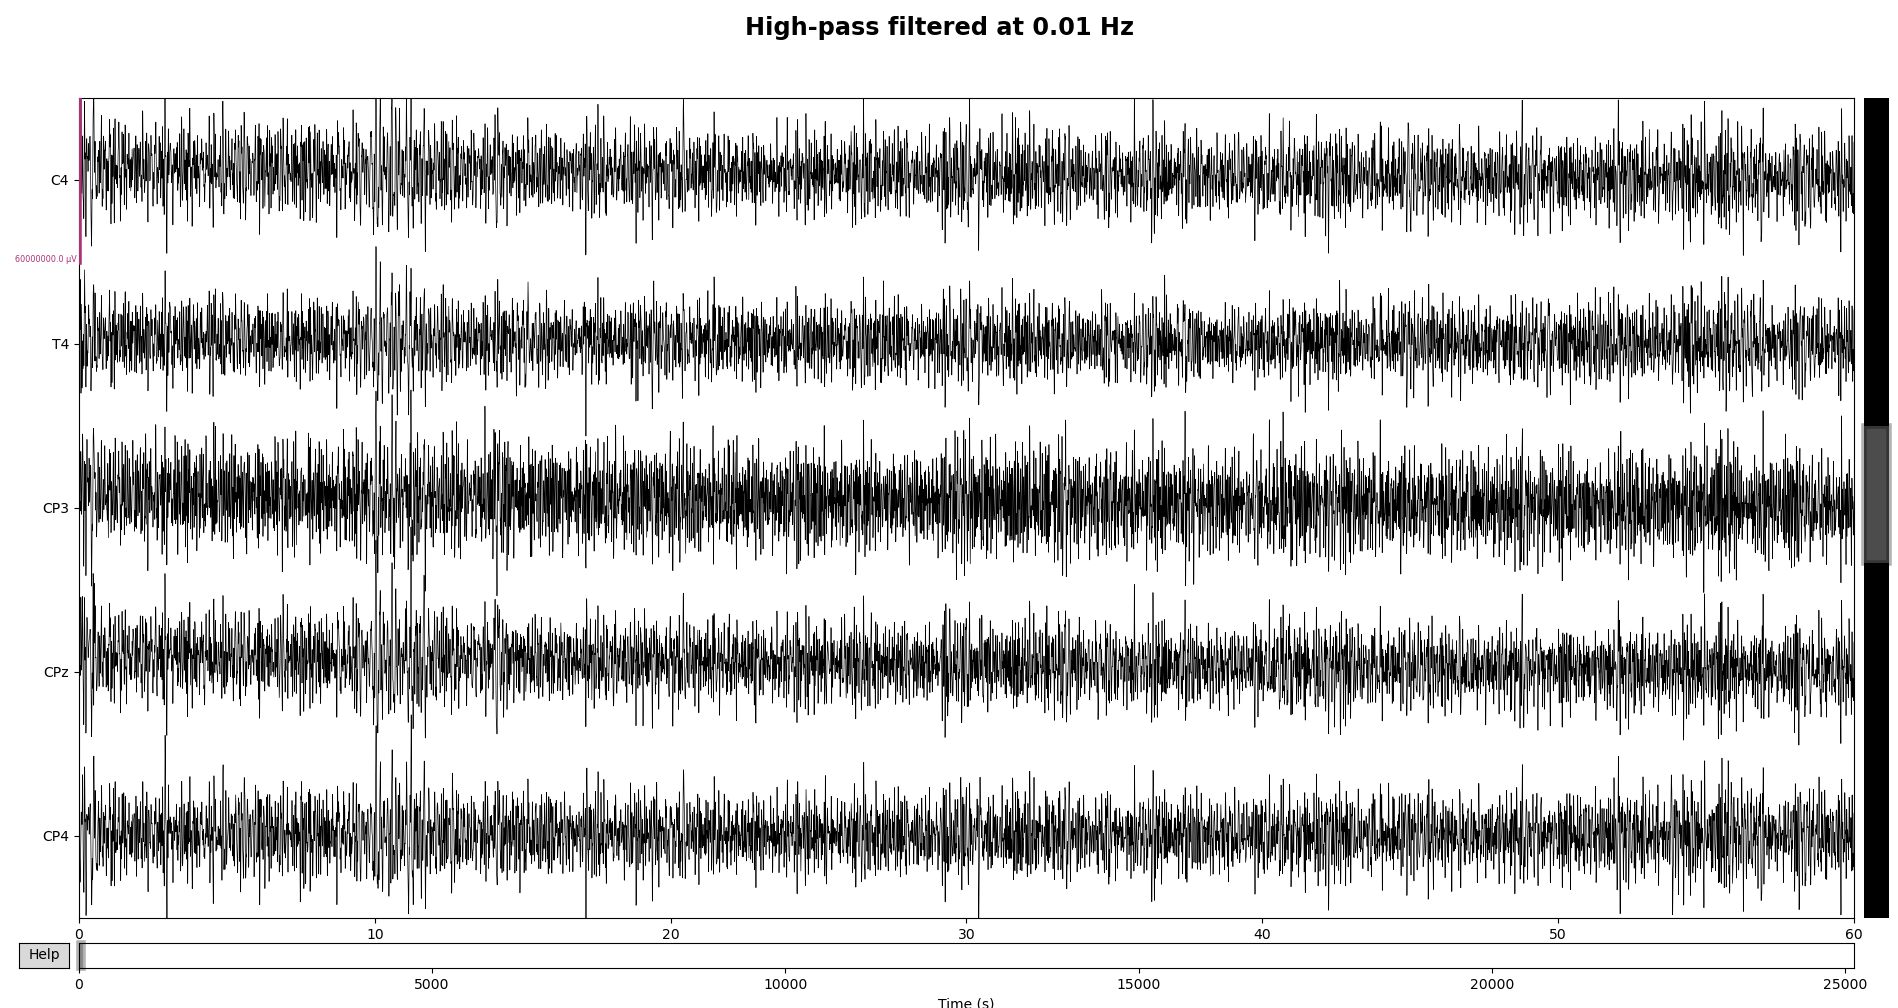

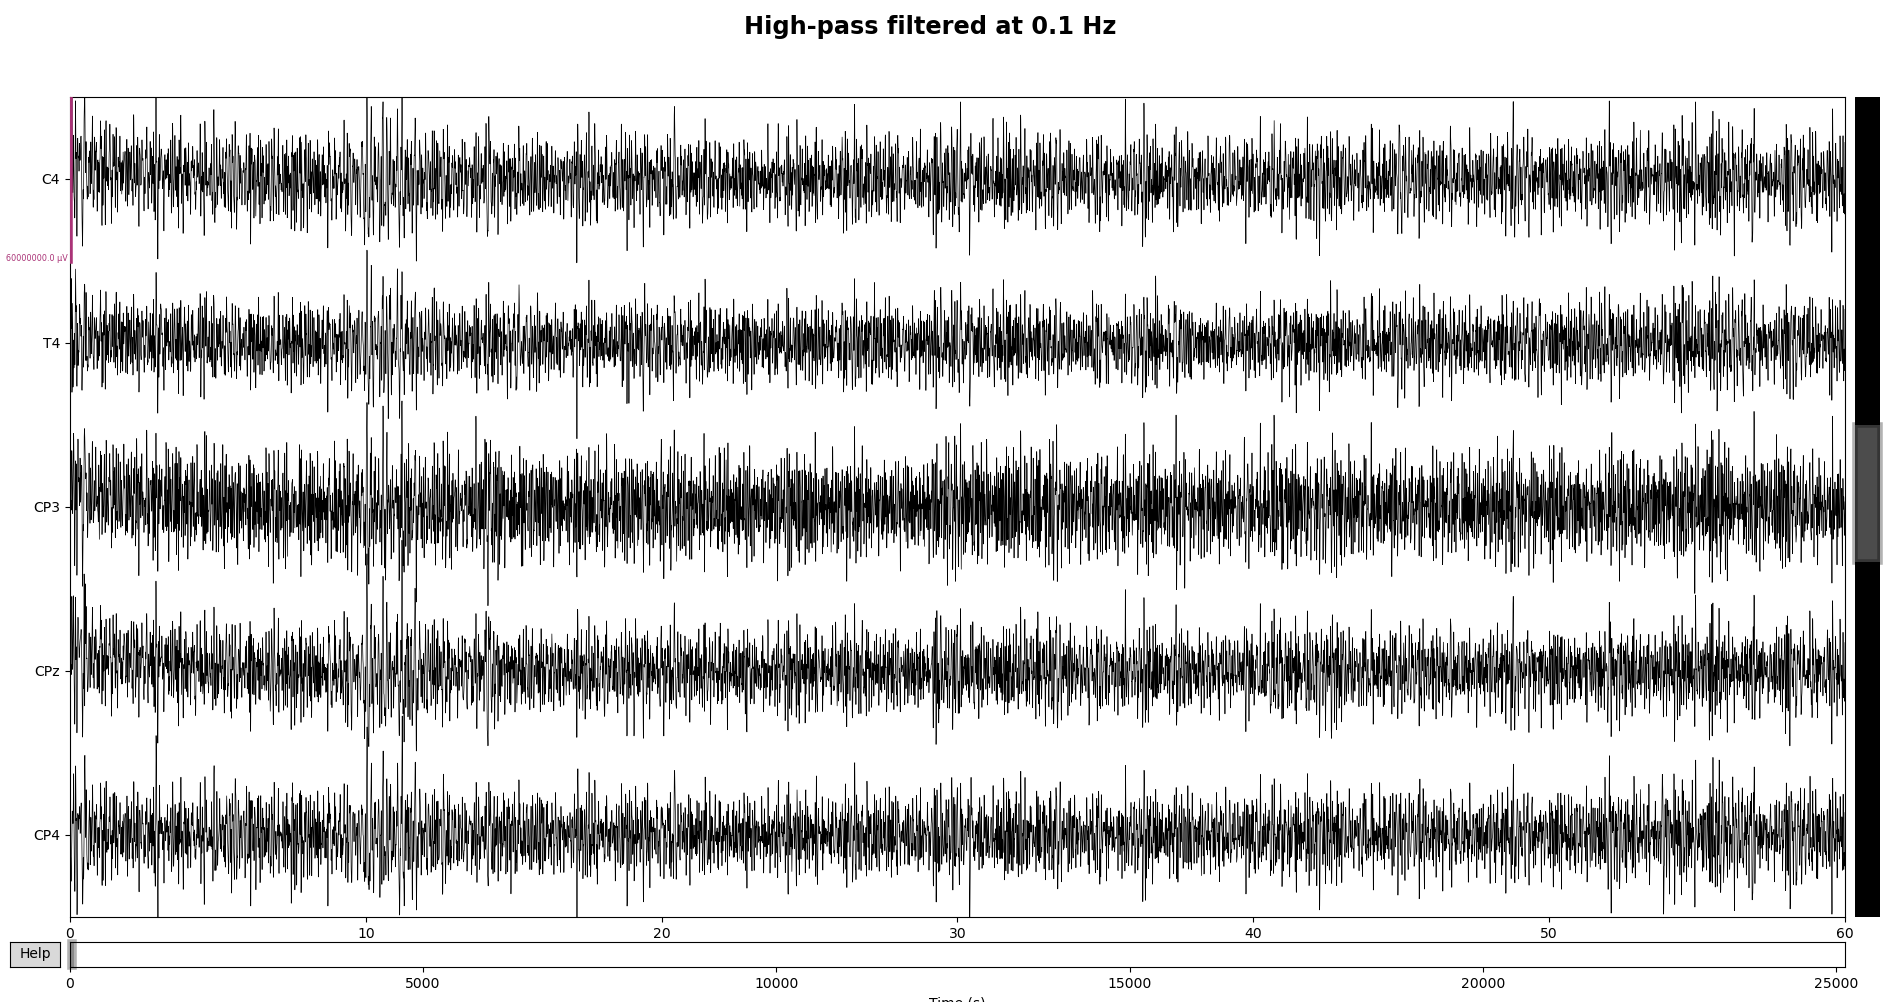

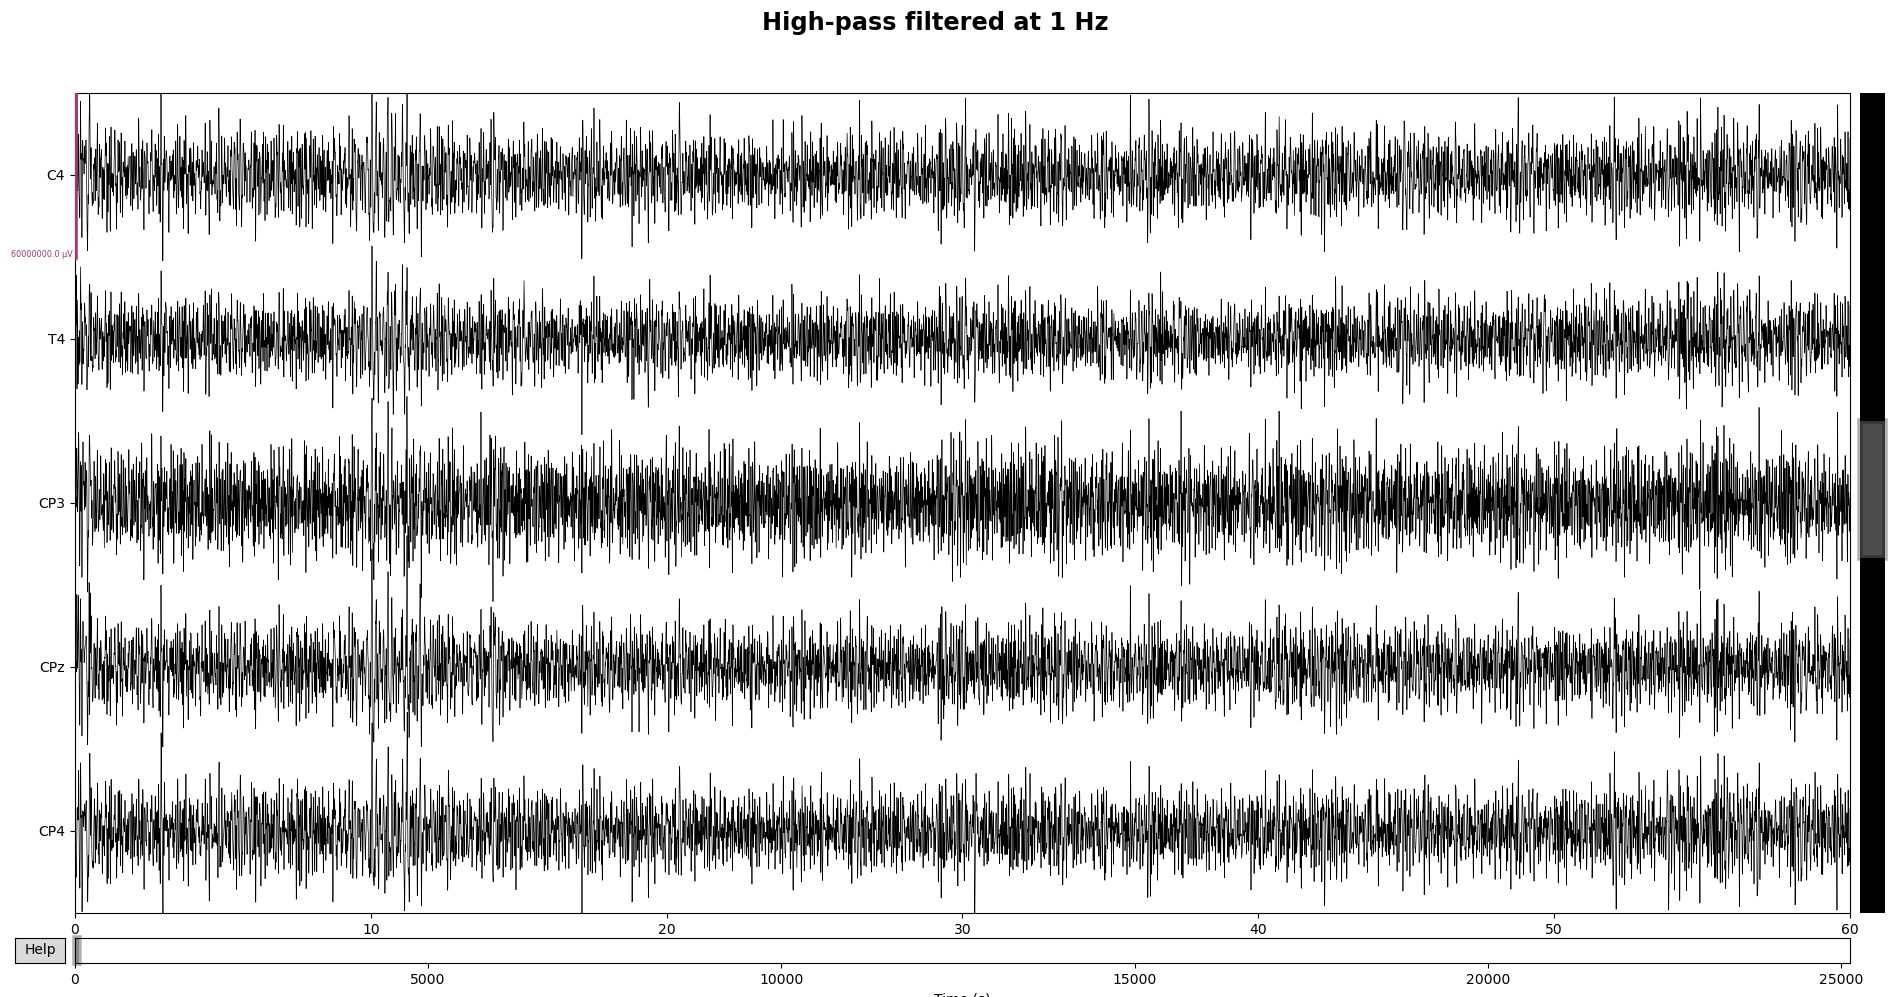

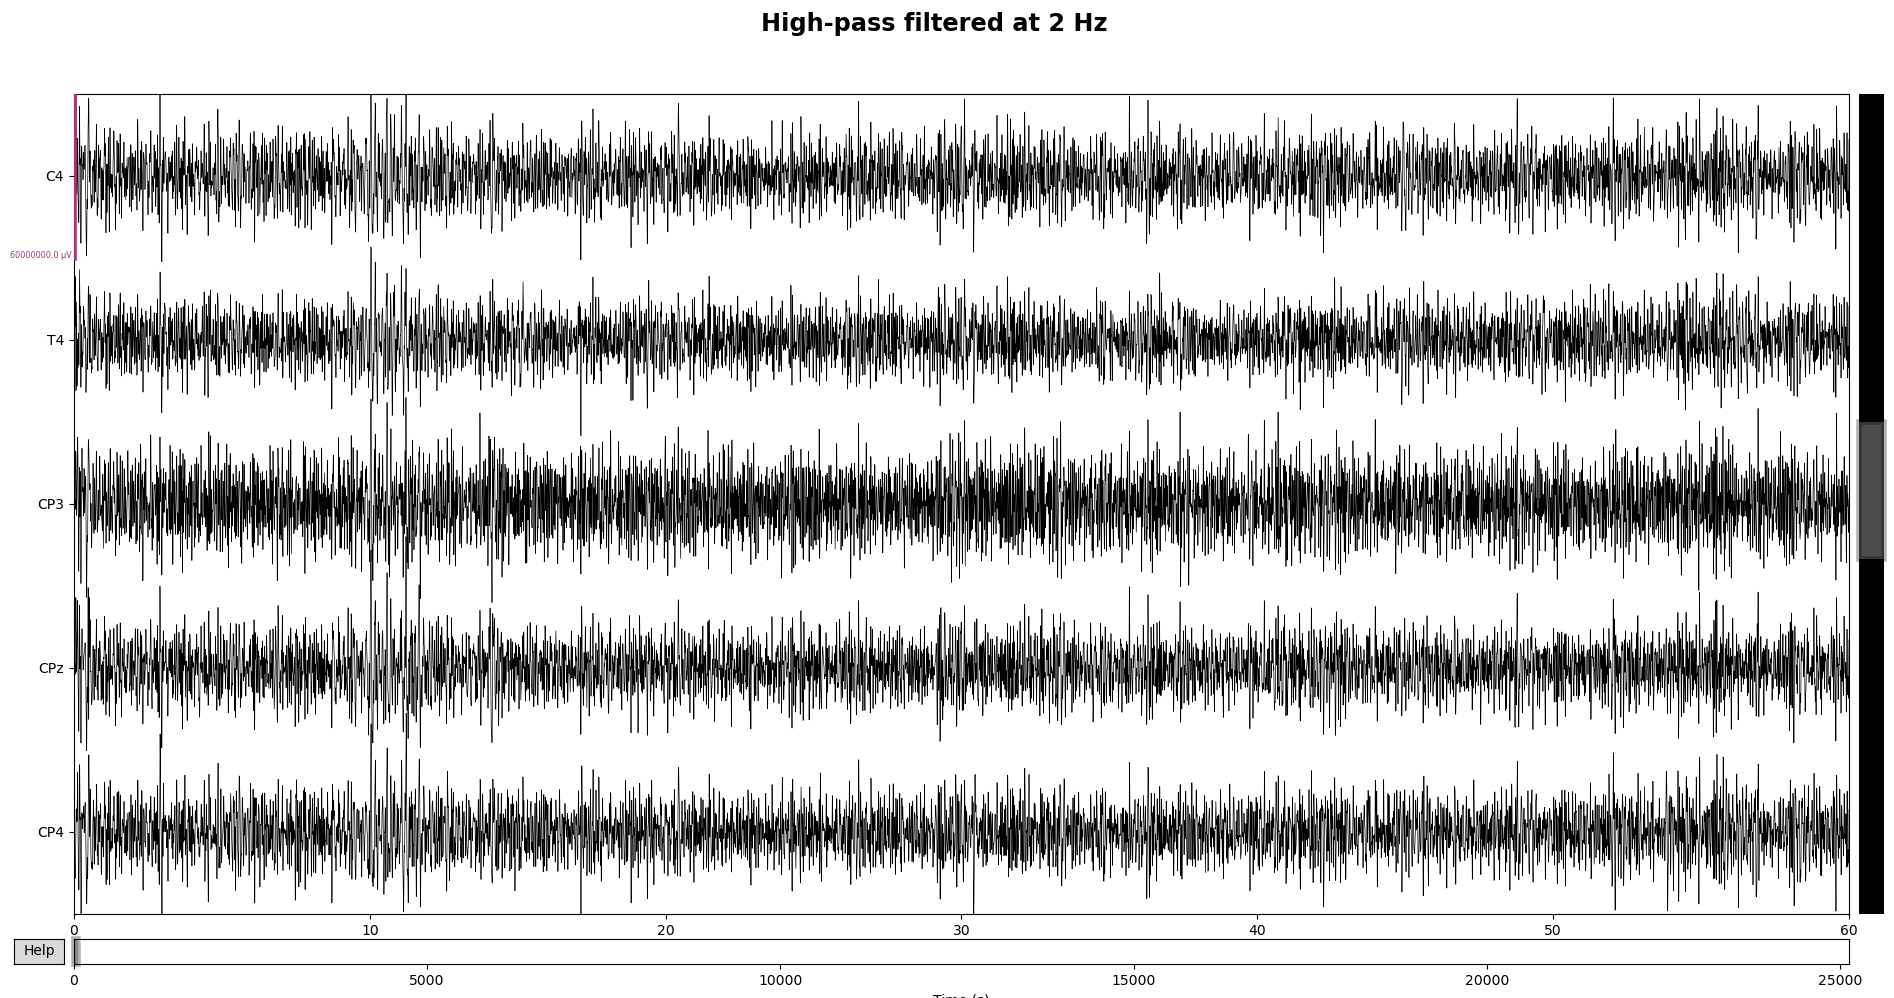

### Combining our raw data from each session into MNE epochs objects

In [ ]:
sesh_1_epoch = mne.Epochs(sesh_1_raw, events=sesh_1_events, 
                          event_id=events_dict, 
                          #subtract 3 seconds from event,
                          #Add 7 seconds (less one sample),
                          #To get our study's definition of trial
                          tmin=-3, tmax=(7 - 1/256), 
                          baseline=None)

In [ ]:
sesh_2_epoch = mne.Epochs(sesh_2_raw, events=sesh_2_events, 
                          event_id=events_dict, 
                          #subtract 3 seconds from event,
                          #Add 7 seconds (less one sample),
                          #To get our study's definition of trial
                          tmin=-3, tmax=(7 - 1/256), 
                          baseline=None)

### Run a neural network on the unaltered data from sessions 1 and 2

We'll use all the data from session 1 as the training data, and session 2 as the test data. In general, I'm worried that artifacts are significantly distorting my data with exceptionally high and exceptionally low readings occassionally.

There are several ways to deal with that - for now, in normalizing, I'm using sklearn's RobustScaler to hopefully deal with that.

Also, note that I should probably do this standardization upstream, at the individual participant level rather than across just the channels. However, that means I won't be able to run filters across the whole dataset. To do this properly, I'll need to do all my filtering and extraction at the individual level, and then concatenate my data on the backend, taking it out of 18 individual epochs.

In [ ]:
#setting scalings=median uses sklearn.preprocessing.RobustScaler
#Uses a median and interquartile range methodology that should be more
#robust to outliers
mne_scaler = mne.decoding.Scaler(scalings='median')
#fit and transform to session 1 data
sesh_1_raw_mne_scaled = mne_scaler.fit_transform(sesh_1_epoch.get_data())

In [ ]:
#reorient tensor to be loaded into neural network
sesh_1_raw_mne_scaled = np.reshape(sesh_1_raw_mne_scaled, 
                                   (sesh_1_raw_mne_scaled.shape[0],
                                   sesh_1_raw_mne_scaled.shape[2],
                                   sesh_1_raw_mne_scaled.shape[1]))

In [ ]:
#reshape y to a one dimensional list
sesh_1_combined_y = np.reshape(sesh_1_combined_y, sesh_1_combined_y.shape[0])
#Current classes are 1-5, need to recode 0-4 for categorization
sesh_1_combined_y -= 1
#convert to categorical
sesh_1_combined_y = utils.to_categorical(sesh_1_combined_y, num_classes=5)

**Repeat the steps for session 2**

In [ ]:
#setting scalings=median uses sklearn.preprocessing.RobustScaler
#Uses a median and interquartile range methodology that should be more
#robust to outliers
mne_scaler = mne.decoding.Scaler(scalings='median')
#fit and transform to session 1 data
sesh_2_raw_mne_scaled = mne_scaler.fit_transform(sesh_2_epoch.get_data())
#reorient tensor to be loaded into neural network
sesh_2_raw_mne_scaled = np.reshape(sesh_2_raw_mne_scaled, 
                                   (sesh_2_raw_mne_scaled.shape[0],
                                   sesh_2_raw_mne_scaled.shape[2],
                                   sesh_2_raw_mne_scaled.shape[1]))

In [ ]:
#reshape y to a one dimensional list
sesh_2_combined_y = np.reshape(sesh_2_combined_y, sesh_2_combined_y.shape[0])
#Current classes are 1-5, need to recode 0-4 for categorization
sesh_2_combined_y -= 1
#convert to categorical
sesh_2_combined_y = utils.to_categorical(sesh_2_combined_y, num_classes=5)

In [ ]:
sesh_1_combined_y.shape

**Build the model** Built very closely on https://justlv.medium.com/using-ai-to-read-your-thoughts-with-keras-and-an-eeg-sensor-167ace32e84a

In [ ]:
#Build the model
model = Sequential()
model.add(Conv1D(40, 6, strides=2, padding='same', activation='relu', 
                 input_shape=(sesh_1_raw_mne_scaled.shape[1], 
                              sesh_1_raw_mne_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Conv1D(40, 4, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Conv1D(40, 3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(sesh_1_raw_mne_scaled, sesh_1_combined_y, 
                    batch_size=60, epochs=15, 
                    validation_data=(sesh_2_raw_mne_scaled, 
                                     sesh_2_combined_y), 
                    verbose=1)

In [ ]:
# Check out our train loss and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
# Check out our train accuracy and test accuracy over epochs
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
#Visualizing at all channels, 1 epoch at a time
subject_A_session_1_epoch_no_baseline.plot(scalings='auto', 
                                           n_epochs=1);

**Raw data**

### Visualizing the artifacts the original author's identified and excluded from analysis

The original authors visually inspected all the data and used their judgment and experience with BCI data to manually decide which channels to exclude from analysis. In order to inform my choices on filtering, I will graph and examine those problematic signals to inform my filtering choices.

Here is the table showing all the exclusions the authors made: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/table/pone.0123727.t001/

From that table, here is the relevant information for subject A:

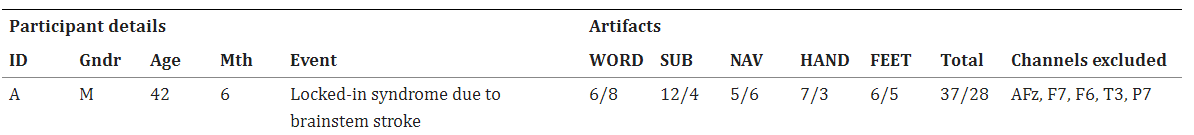

In [ ]:
#picks sets channels to visualize, 5 reported bad channels plus five others
bad_channels = ['AFz', 'F7', 'F6', 'T3', 'P7']
good_channels = ['FCz', 'F8', 'F3', 'T4', 'P5']
picks = bad_channels + good_channels


In [ ]:
#show just good channels, MNE doesn't show the channels in the order passed
#if I graph all together
fig = subject_A_session_1_epoch_no_baseline.plot(picks=good_channels, 
                                                 scalings=30, 
                                                 n_epochs=1)
fig.subplots_adjust(top=0.9)
fig.suptitle('Good channels as defined by study authors', weight='bold', 
             size='xx-large')

In [ ]:
#show just bad channels, MNE doesn't show the channels in the order passed
#if I graph all together
fig = subject_A_session_1_epoch_no_baseline.plot(picks=bad_channels, 
                                                 scalings=30, 
                                                 n_epochs=1)
fig.subplots_adjust(top=0.9)
fig.suptitle('Bad channels as defined by study authors', weight='bold', 
             size='xx-large')

It appears the channels the researchers excluded were extremely noisy with high frequency data. See the screenshots below for the raw visualized data from subject A, showing the 'bad channels' identified by the researchers vs nearby 'good channels' I selected to compare against:

'Bad channels' showing fifth trial:
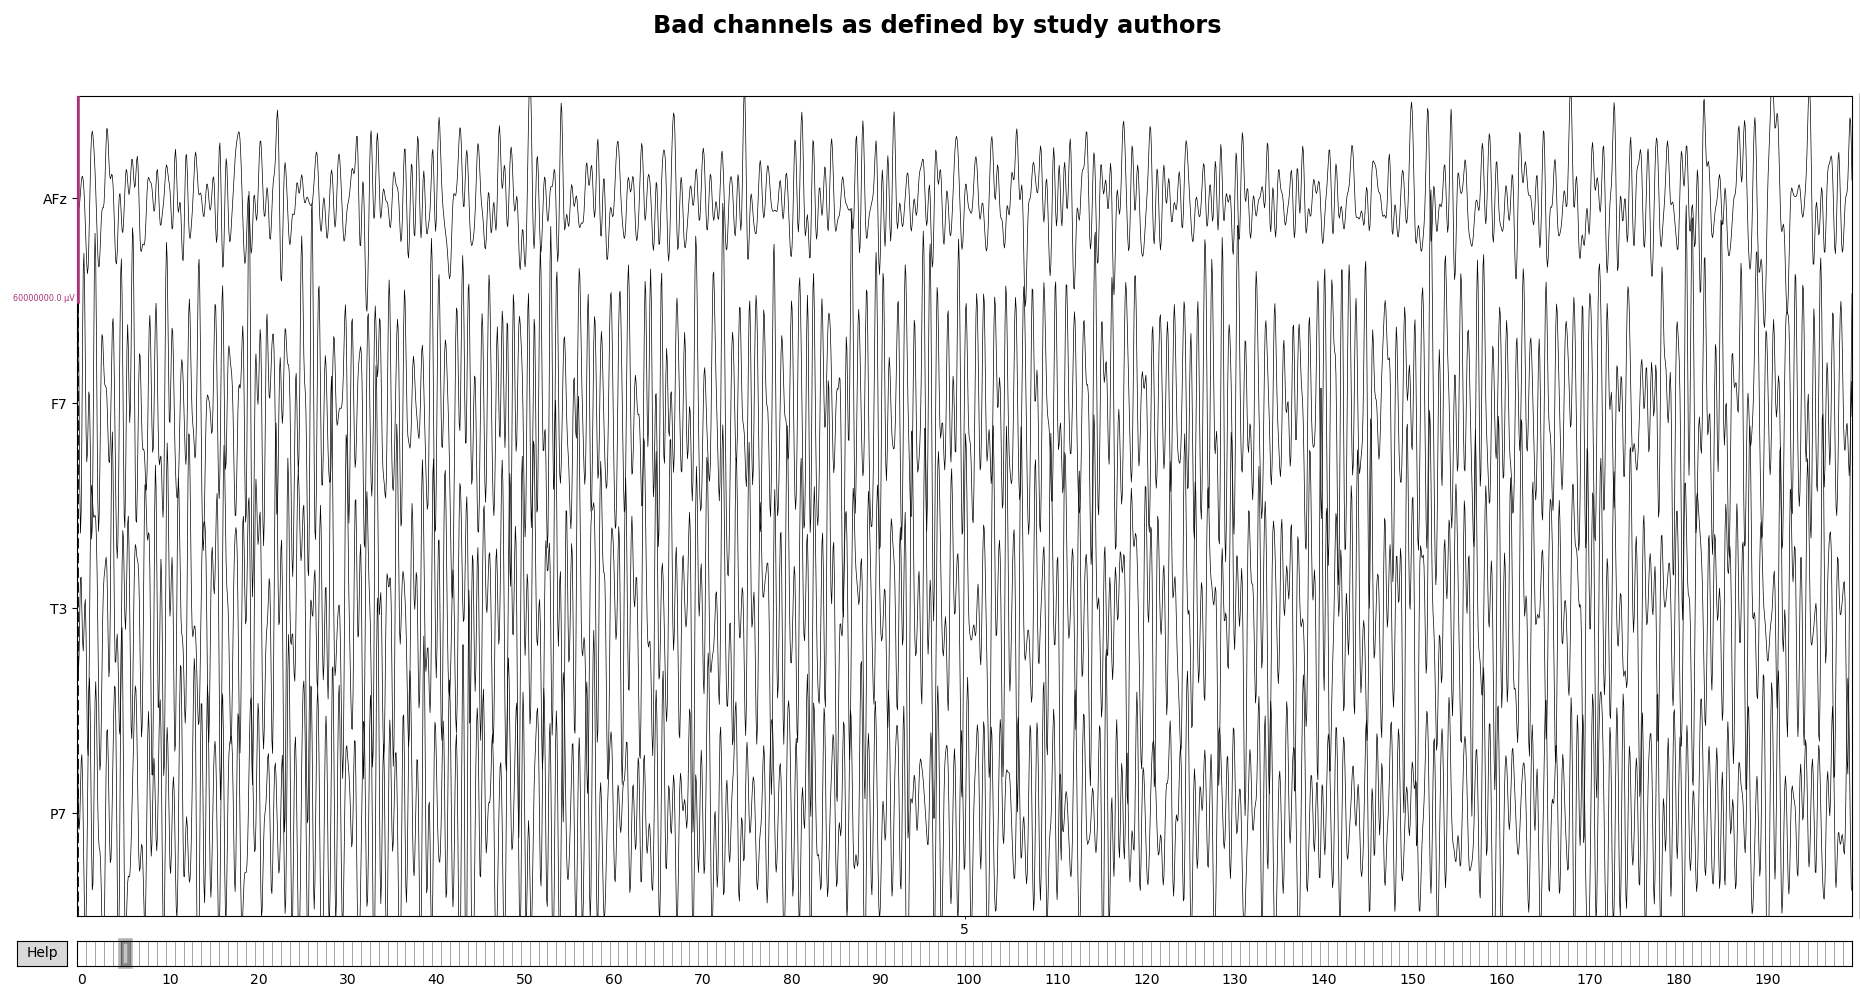

'Good channels' showing fifth trial:
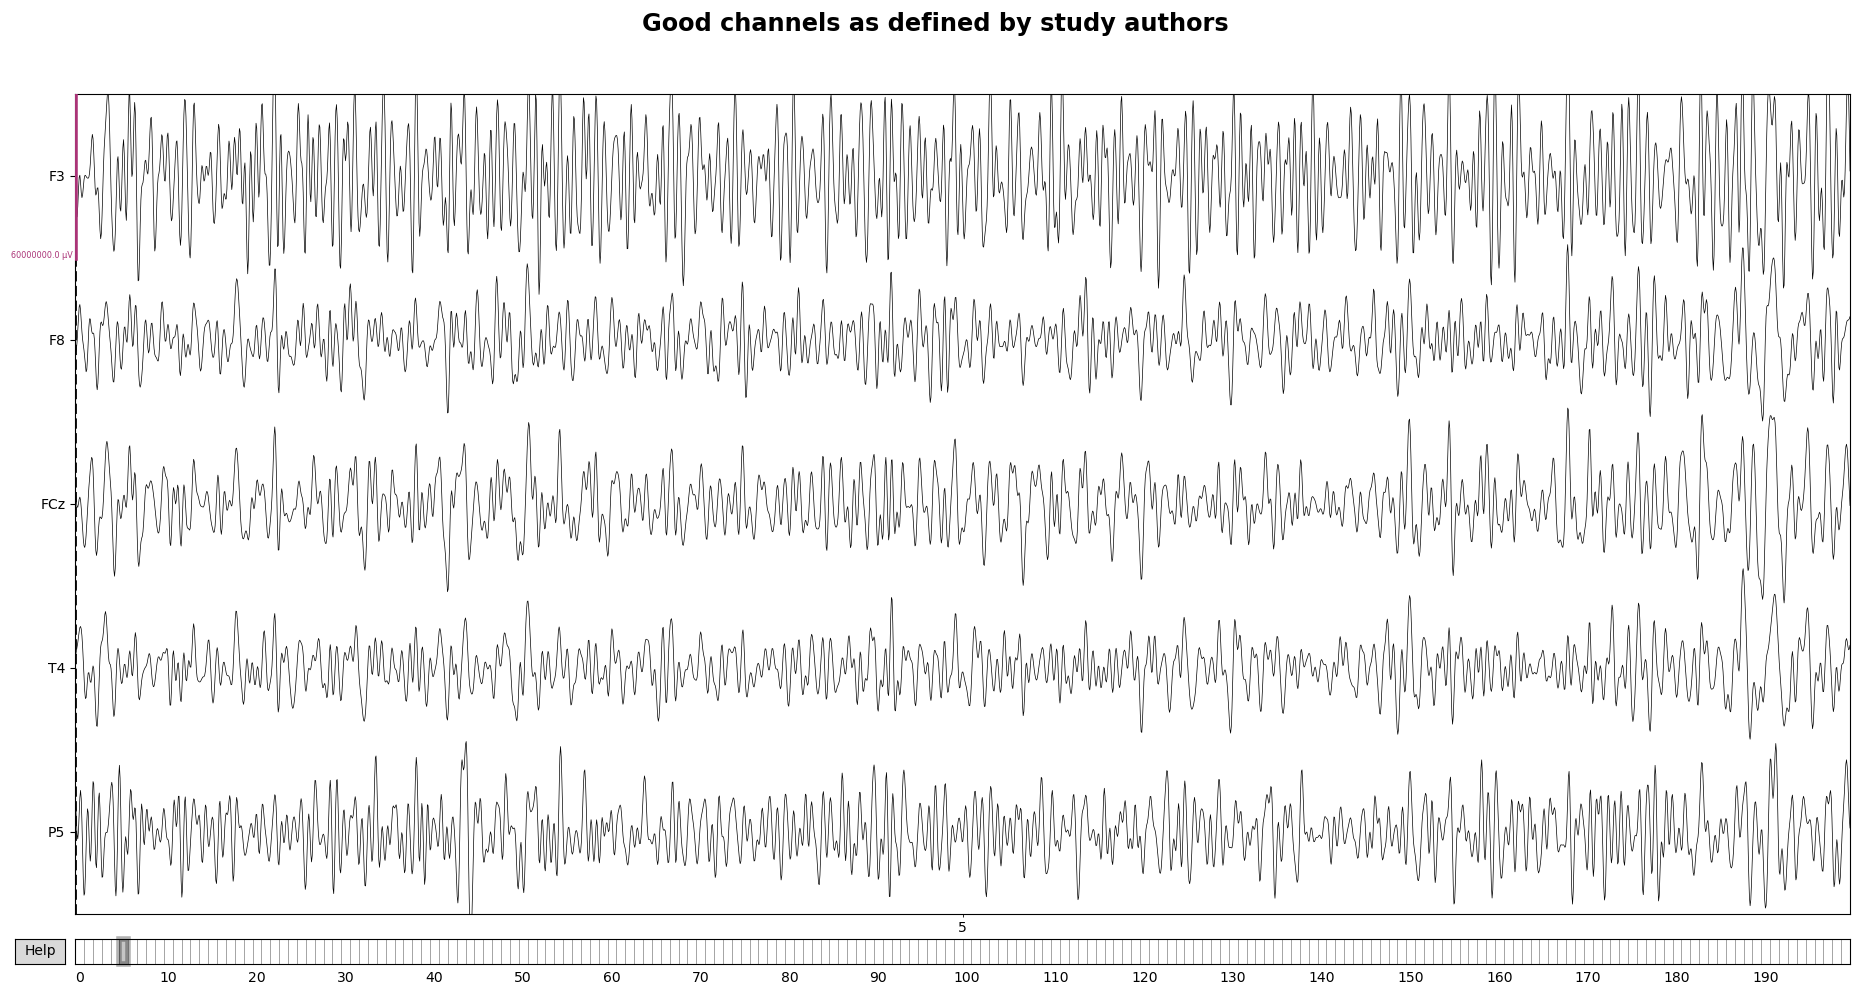

'Bad channels' showing 124th trial:
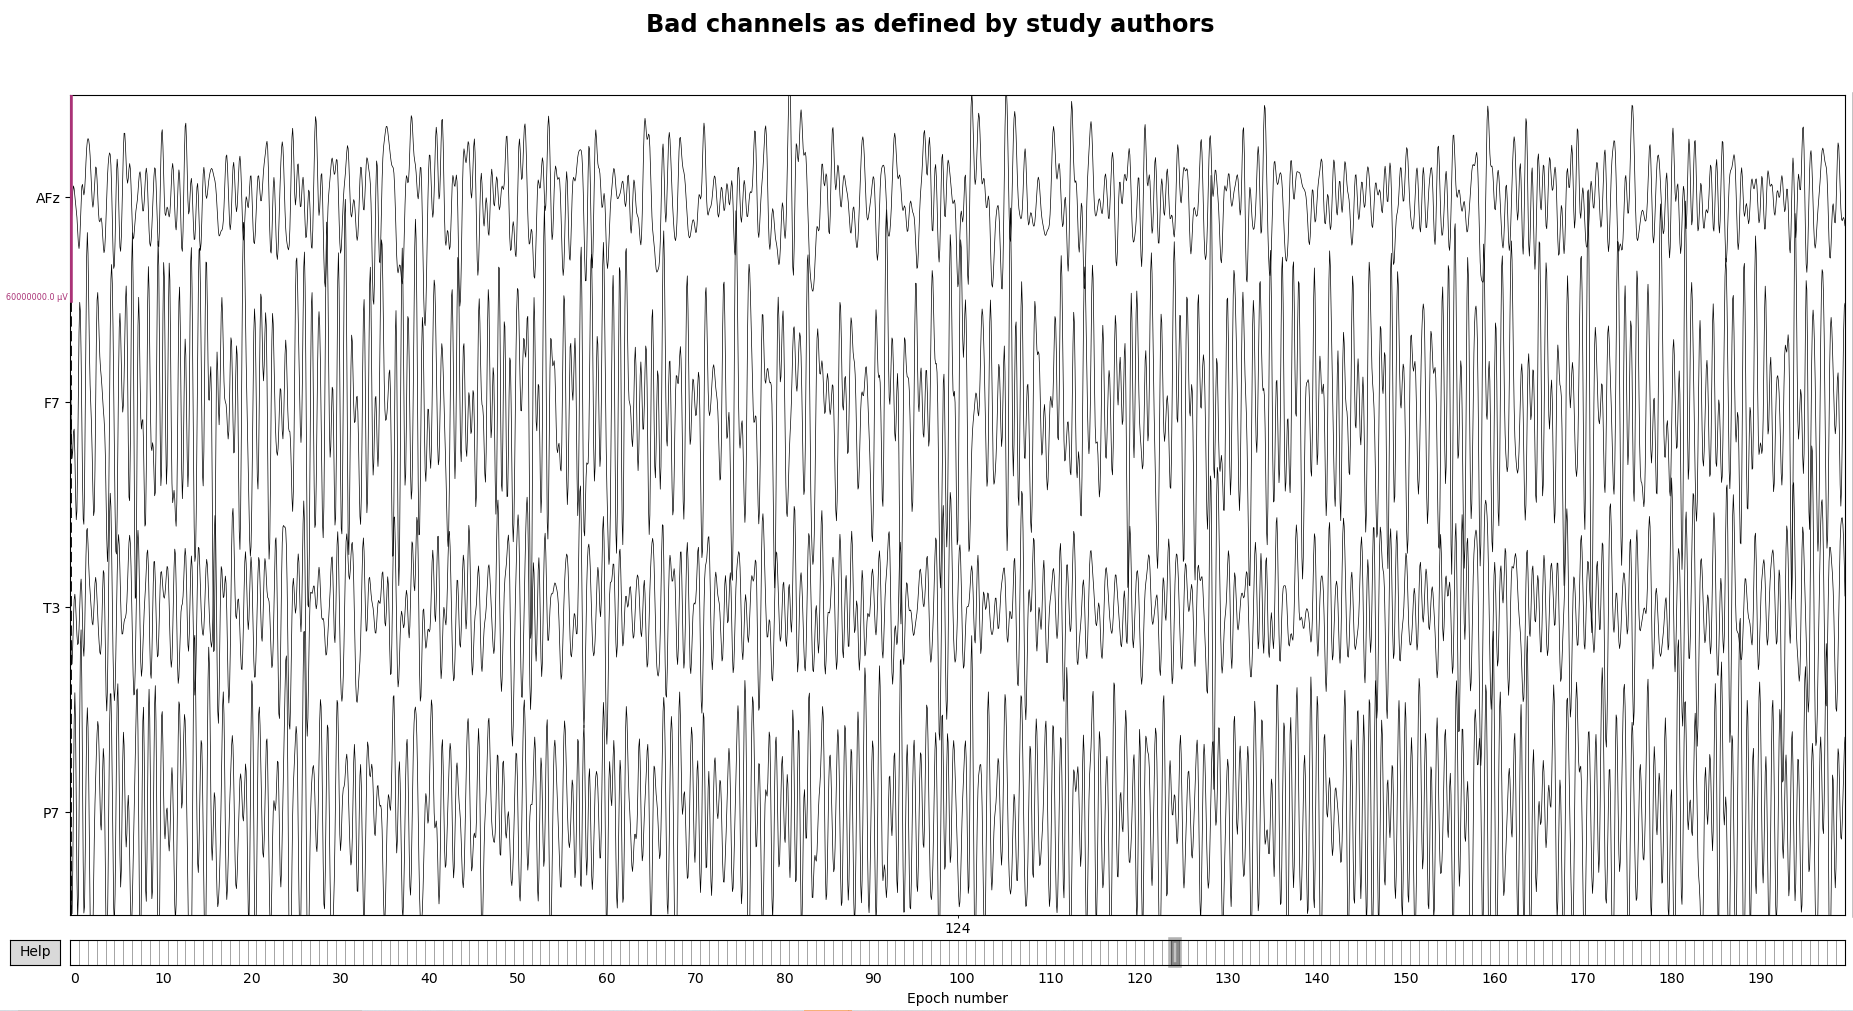

'Good channels' showing 124th trial:
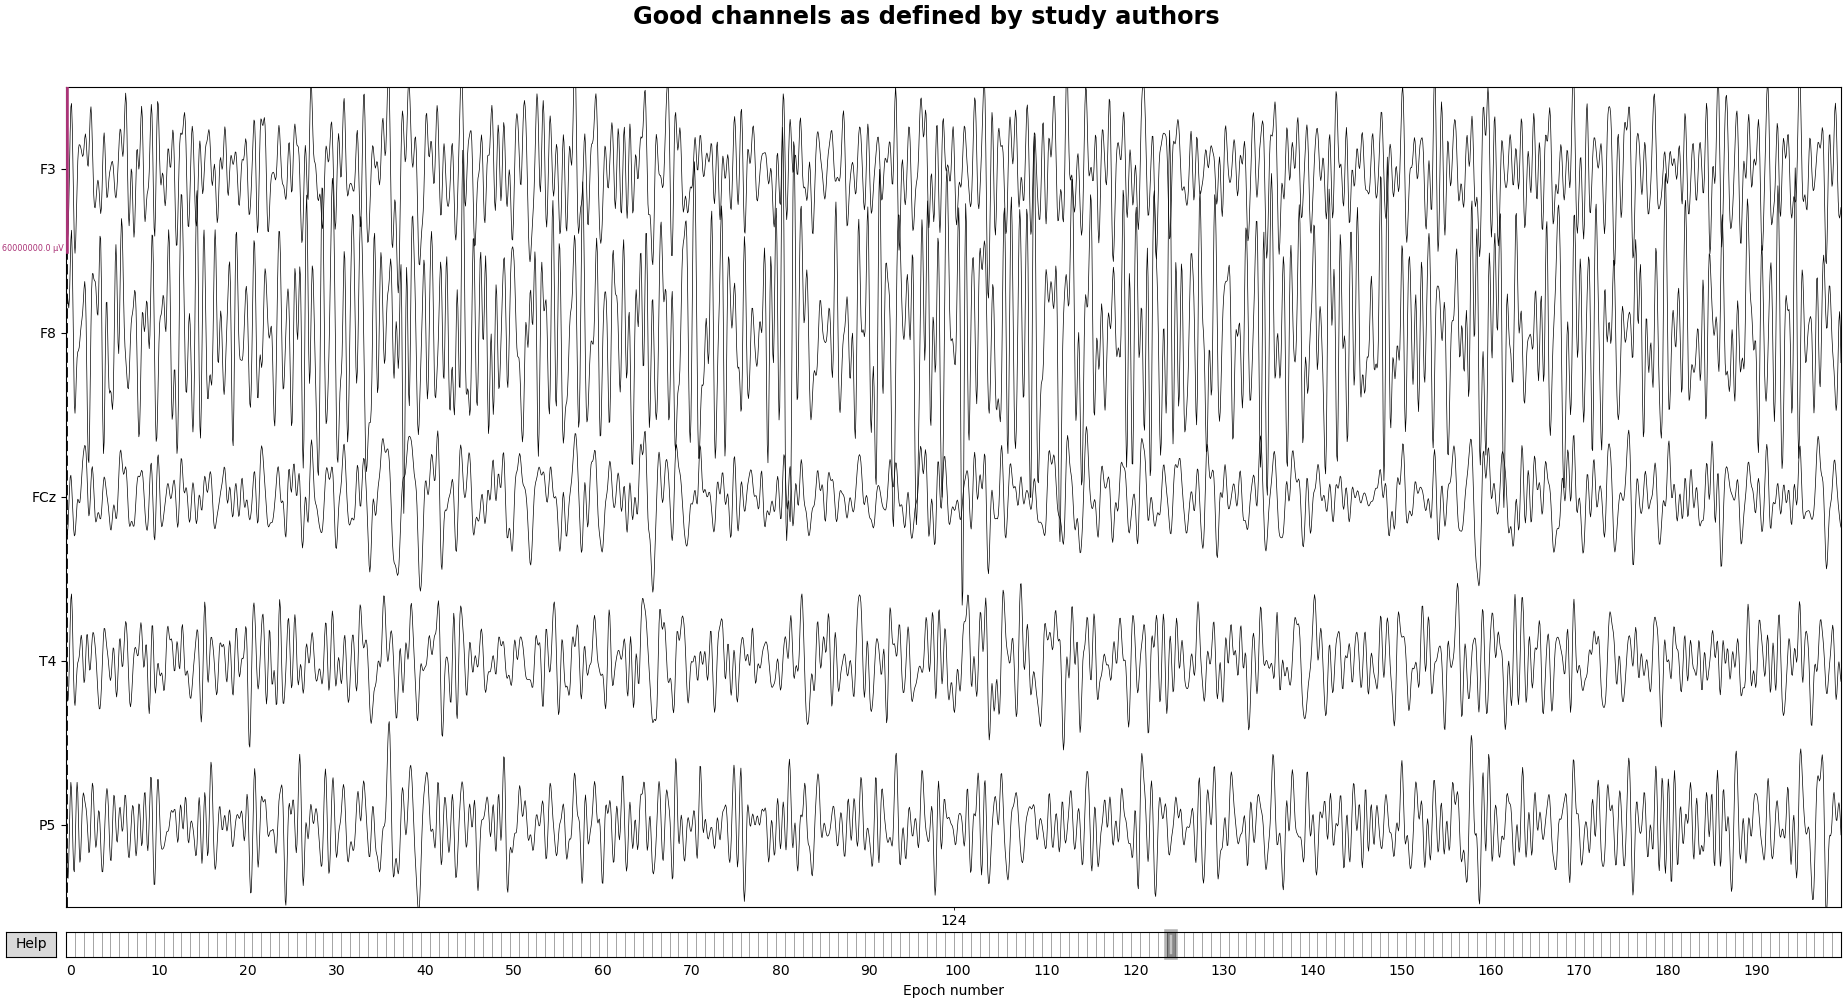

**However, while this appears to be the pattern in general, it wasn't always the case in all trials. E.g.,**

'Bad channels' showing 99th trial:
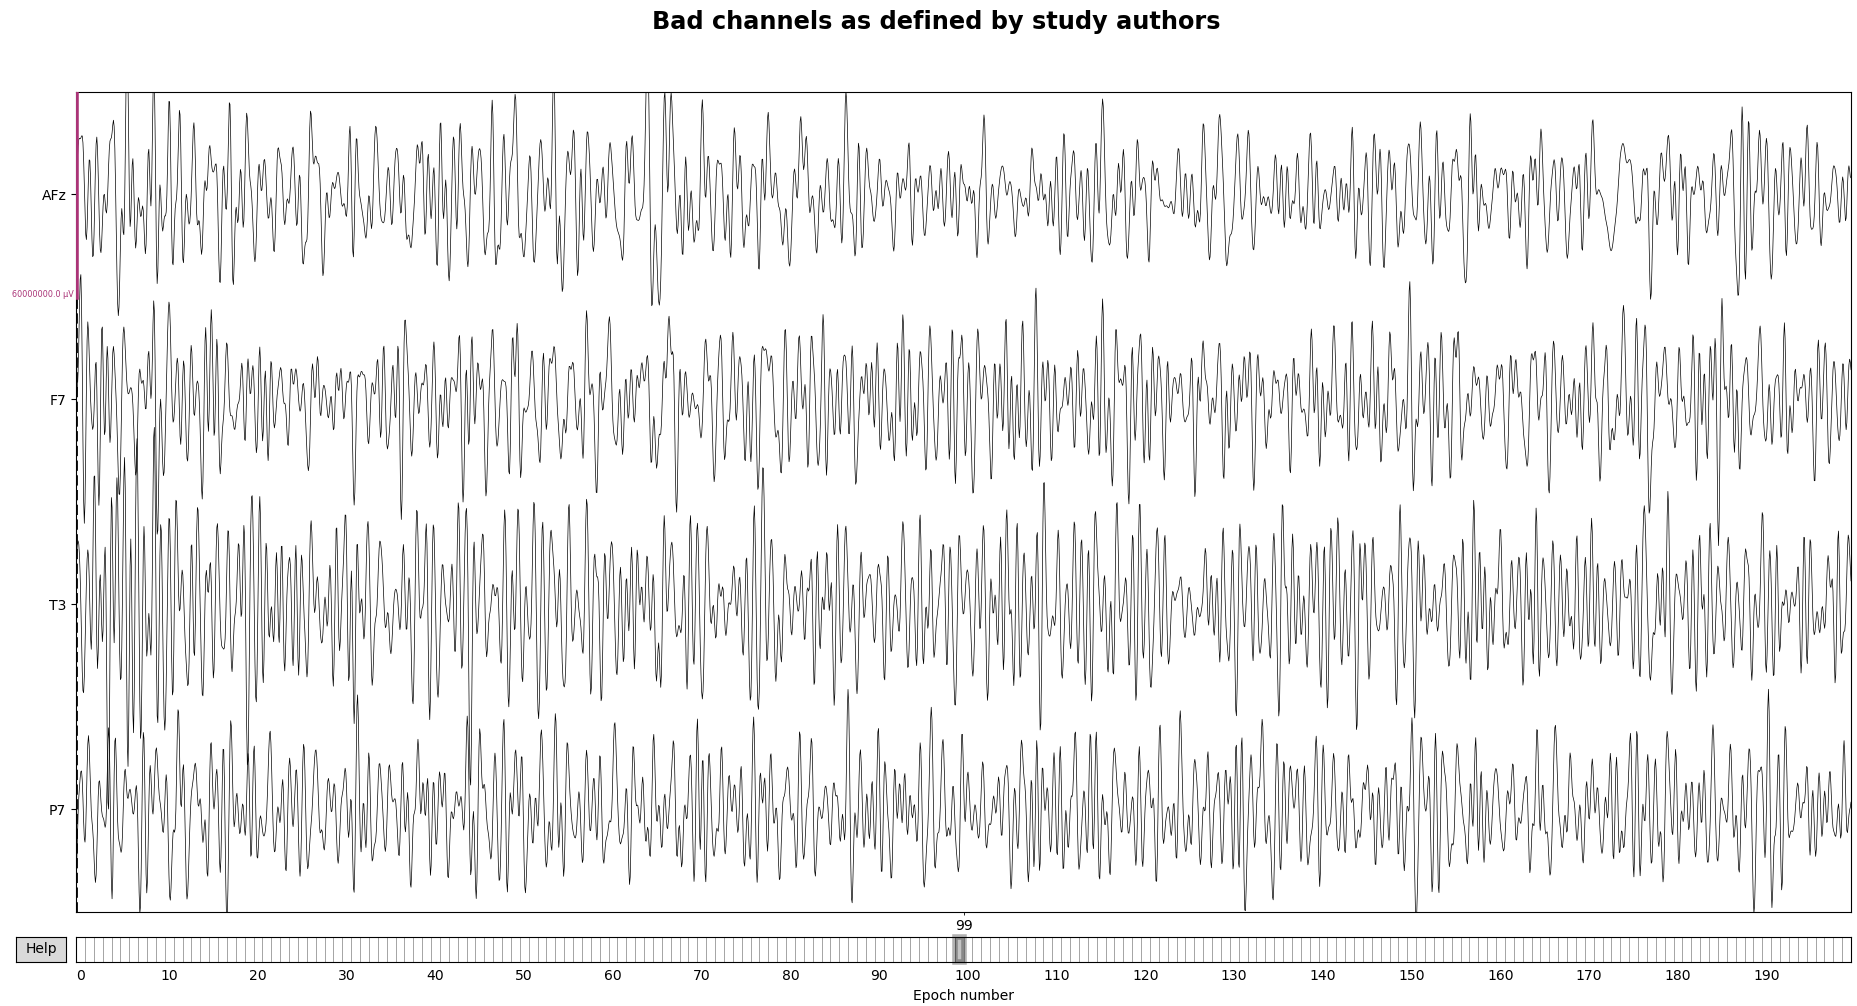

'Good channels' showing 99th trial:
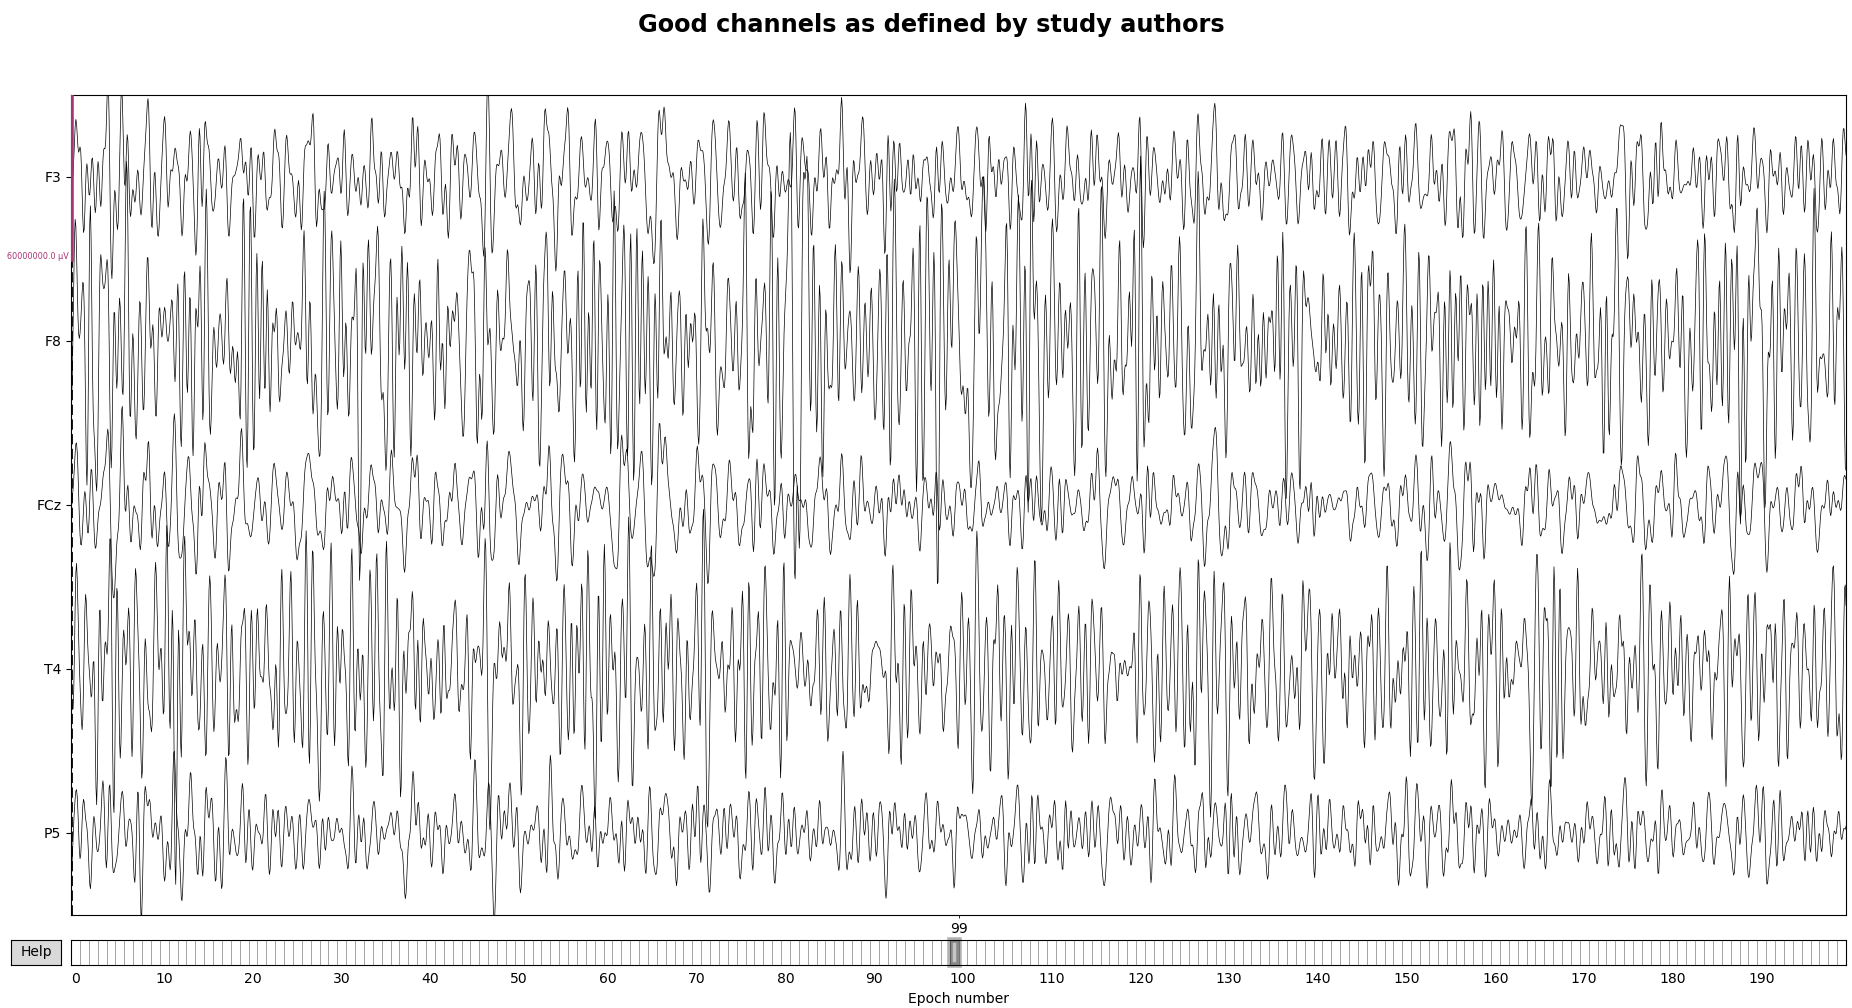

### Signal Space Projection (SSP)

At this point, I'm not sure if SSP will help clean up artifacts. Let's visualize our data in a different way to look for artifacts.

In [ ]:
subject_A_session_1_epoch_no_baseline.plot_image(combine='mean')

In this data from subject A session 1 there are a few places we might have artifacts, but not many places jump out clearly to me. First, here is the whole picture:

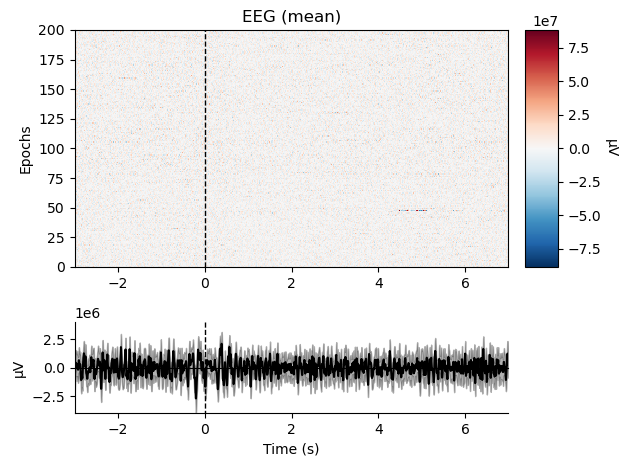

It appears we have an artifact in trial 47:
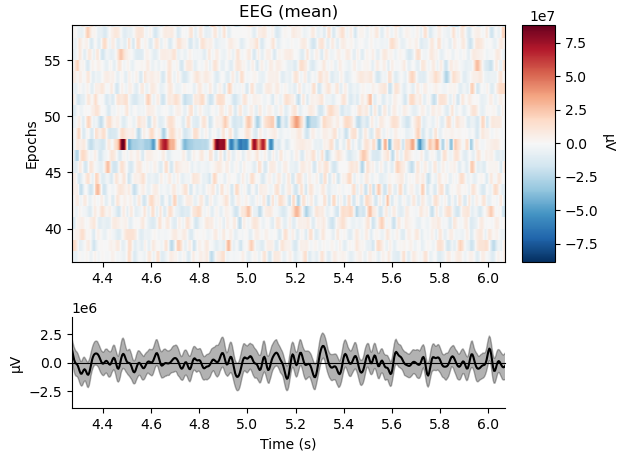

Another potentially in trial 159:
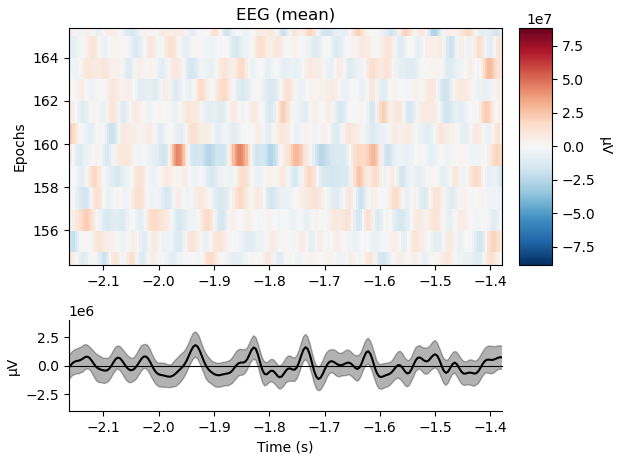

But in general I'm not seeing the big artifacts they describe in this article:
https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#tut-artifact-overview

Additionally, SSP doesn't seem particularly useful in a BCI device on an ongoing basis, because it is all backward looking / it requires looking at a period of time, converting the data into projectors, and dropping some of them. As a result, if I want to do SSP projection filtering, I should do it at the epoch level, and I need to use the exact same setting across all epochs (to simulate that code working in production). On the flipside, if I calculate the projectors on the epoched data, and do it once per epoch, it seems more likely that I will remove the signal I'm interested in (the result of each trial). Therefore, **I should de-prioritize SSP filtering for now**. If I am not getting good results with my other preprocessing approaches, I can circle back to this.

If I circle back, instructions to do SSP work are here:

https://mne.tools/stable/auto_tutorials/preprocessing/50_artifact_correction_ssp.html

I can either calculate and remove SSP projectors at the raw or epoch level:

https://mne.tools/stable/generated/mne.compute_proj_epochs.html

https://mne.tools/stable/generated/mne.compute_proj_raw.html

I may also need to set the eeg reference - in my case, I need to use the default average of all channels: https://mne.tools/stable/generated/mne.set_eeg_reference.html

### For visualizations at the end of the project

Once I find out which SSP projectors I'm going to keep on, I should chart the effect. Here's how to do it.

In [ ]:
#Lets try visualizing these projectors - first data without projectors
epoch_dict['sub_A_sesh_1'].del_proj()
with mne.viz.use_browser_backend('matplotlib'):
    fig = epoch_dict['sub_A_sesh_1'].plot(scalings=30, n_epochs=3, 
                                          events=event_dict['sub_A_sesh_1'])
fig.subplots_adjust(top=0.9)  # make room for title
fig.suptitle('Without ECG projectors', size='xx-large', weight='bold')

In [ ]:
#Lets try visualizing these projectors - now with projectors
epoch_dict['sub_A_sesh_1'].add_proj(projs)
with mne.viz.use_browser_backend('matplotlib'):
    fig = epoch_dict['sub_A_sesh_1'].plot(scalings=5, n_epochs=3, 
                                         events=event_dict['sub_A_sesh_1'])
fig.subplots_adjust(top=0.9)  # make room for title
fig.suptitle('With ECG projectors', size='xx-large', weight='bold')

### Loading the data into a convolutional neural network for the first time to test that process and make sure I know what shape to use in pre-processing

In [ ]:
subject_A_session_1_epoch_no_baseline = mne.Epochs(subject_A_session_1_raw, 
                                       events=events, 
                                       event_id=events_dict, 
                                       #subtract 3 seconds from event,
                                       #Add 7 seconds (less one sample),
                                       #To get their definition of trial
                                       tmin=-0.2, tmax=(2.8 - 1/256), 
                                       baseline=None)

**Let's try building a neural network with this raw data to predict all 5 classes**

For this first attempt we're going to split our day 1 data into train and test just to see how well the model does and to get things initialized quickly

In [ ]:
#setting scalings=median uses sklearn.preprocessing.RobustScaler
#Uses a median and interquartile range methodology that should be more
#robust to outliers
mne_scaler = mne.decoding.Scaler(scalings='median')
#fit and transform to subject A session 1 data
sub_a_sesh_1_mne_scaled = mne_scaler.fit_transform(subject_A_session_1_epoch_no_baseline.get_data())
#reorient tensor to be loaded into neural network
sub_a_sesh_1_mne_scaled = np.reshape(sub_a_sesh_1_mne_scaled, 
                                   (sub_a_sesh_1_mne_scaled.shape[0],
                                   sub_a_sesh_1_mne_scaled.shape[2],
                                   sub_a_sesh_1_mne_scaled.shape[1]))

In [ ]:
#Our trial classes from original raw dataset
[y] = df_0['y']
y = np.reshape(y, 200)
#Current classes are 1-5, need to recode 0-4 for categorization
y = [num - 1 for num in y]
#convert to categorical
y = utils.to_categorical(y, num_classes=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sub_a_sesh_1_mne_scaled, y, 
                                                    stratify=y)

**Build the model** Built very closely on https://justlv.medium.com/using-ai-to-read-your-thoughts-with-keras-and-an-eeg-sensor-167ace32e84a

In [ ]:
#Build the model
model = Sequential()
model.add(Conv1D(40, 6, strides=2, padding='same', activation='relu', 
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Conv1D(40, 4, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Conv1D(40, 3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=60, epochs=15, 
                    validation_data=(X_test,y_test), verbose=1)

In [ ]:
# Check out our train loss and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
# Check out our train accuracy and test accuracy over epochs
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

### Below here is scratch work / likely to be deleted later on

**Decimating down to every 2nd sample** Effectively means we're now looking at data at 128 hertz. Note that this could lead to artifacts since I'm not filtering in advance (at this point)

In [ ]:
subject_A_session_1_2nd_decimated = mne.Epochs(subject_A_session_1_raw, 
                                                 events=events, 
                                                 event_id=events_dict, 
                                                 tmin=-3, tmax=7,
                                                decim=2)
subject_A_session_1_2nd_decimated.plot(scalings=30, 
                                           n_epochs=1);

**Decimating down to every 8th sample** Effectively means we're now looking at data at 32 hertz. Note that this could lead to artifacts since I'm not filtering in advance (at this point)

In [ ]:
subject_A_session_1_8th_decimated = mne.Epochs(subject_A_session_1_raw, 
                                                 events=events, 
                                                 event_id=events_dict, 
                                                 tmin=-3, tmax=7,
                                                decim=8)
subject_A_session_1_8th_decimated.plot(scalings=30, 
                                           n_epochs=1);

**Decimating down to every 4th sample** Effectively means we're now looking at data at 64 hertz. Note that this could lead to artifacts since I'm not filtering in advance (at this point)

In [ ]:
subject_A_session_1_4th_decimated = mne.Epochs(subject_A_session_1_raw, 
                                                 events=events, 
                                                 event_id=events_dict, 
                                                 tmin=-3, tmax=7,
                                                decim=4)
subject_A_session_1_4th_decimated.plot(scalings='auto', 
                                           n_epochs=1);

Eaiser to see decimated, but we are generating a warning and it looks like we are creating some random artifacts in the data. It feels like I should take the mean of each 10 samples though rather than just every 10th sample - could be something to try later.

Other ideas to try:
- detrend
- proj
- baseline (None, None)

**Baseline across entire epoch**
Default setting is (None, 0), i.e. beginning of the the data until time point zero. Setting to (None, None) will use the entire time interval. In general baseline correction means finding the average voltage over each epoch (or a different period of time within that epoch) and then subtracting that average from the entire epoch.

In [ ]:
subject_A_session_1_epoch_wide_baseline = mne.Epochs(subject_A_session_1_raw, 
                                       events=events, 
                                       event_id=events_dict, 
                                       tmin=-3, tmax=7, baseline=(None, None))
subject_A_session_1_epoch_wide_baseline.plot(scalings='auto', 
                                           n_epochs=1);

Very hard to say if this is better. I must either decimate or graph a smaller period of time if I want to be able to visually inspect this data. In general it doesn't appear that anything other than the decimation has produced differences so far.

**Filtering the data**
Read this article when I set up filtering:
https://sapienlabs.org/lab-talk/pitfalls-of-filtering-the-eeg-signal/#:~:text=Digital%20filtering%20is%20a%20common,40%20or%2050%20Hz%20Hz.

And this one for the python tools to use:
https://justlv.medium.com/using-ai-to-read-your-thoughts-with-keras-and-an-eeg-sensor-167ace32e84a

### Trying different methods to scale the data - Do I need to scale / normalize the data?

Looks like we need to scale this thing if I want to be able to see a clear signal. Some kind of averaging of the data also looks like it would be helpful - but one step at a time. Let's try MNE's built in scalers first.

We'll try it two ways - using MNE's default scaler for EEG data, and then by mean and standard deviation (sklearn standard scaling) within each channel.

In [ ]:
mne_default_scaler = mne.decoding.Scaler(info=info)
# sklearn_scaler = mne.decoding.Scaler(scalings=='mean')

**First let's see what our raw data looks like with the mne default scaler**

In [ ]:
X = subject_A_session_1_epoch_no_baseline.get_data()
y = subject_A_session_1_epoch_no_baseline.events
subject_A_session_1_mne_scaled = mne_default_scaler.fit_transform(X, y)

In [ ]:
subject_A_session_1_mne_scaled.shape

In [ ]:
X

It looks like my data might already be scaled. I need to do some more investigating here - and then also figure out how to re-load the scaled data into an epoch for visualization, the below didn't work.

In [ ]:
subject_A_session_1_mne_scaled_epoch = mne.Epochs(subject_A_session_1_mne_scaled, 
                                       events=events, 
                                       event_id=events_dict, 
                                       tmin=-3, tmax=7)

In [ ]:
subject_A_session_1_mne_scaled.plot(picks=[4], scalings='auto', n_epochs=1)

**Now let's see what our data looks like with the sklearn standard scaler**

In [ ]:
#Debug the standard scaler too
subject_A_session_1_standard_scaled = sklearn_scaler.fit_transform(X, y)

**Duplicating the filters from the study**
- Here is the article they reference with instructions on CSP: https://sci-hub.se/10.1109/MSP.2008.4408441

Notes from conversation with Anirudh:

- I should build a supervised network, that will get the best results
- I should just use tensorflow, don't worry about pytorch
- Make a 3 layer neural net, and feed the input into the last layer (or second to last layer) into tsne to make visualization
- He recommends building neural network progressively - start with a super simple neural net (like with excel data I make on a simple classification problem), put it into tsne and umap (umap keeps things more structurally correct)
- Then go to time series data - LSTM (which is an encoder) - in my neural net
- LSTM isn't going to work with 2500 data points per trial (it just won't run) - I could run a transformer model, but I'm not going to have time for that, instead he suggests getting down to 100 samples per LSTM (bunch of ways to do that, could take the median of every 25 measurements, or just take every 25th one)
- He highly recommends I visualize how each channel moves up and down - that will aid my knowledge hugely
    - I can even do matplotlib + animation (google that) to make a gif of how a channel moves in a trial
- I could also train with an auto encoder, it will take an input in (like you could feed it an image) - and it will try to recreate the signal you are feeding it
    - Google cnn autoencoder
- It may be the only transformation I need to do is put all my datapoints between 0 and 1 - maybe a log transformation - in general the neural nets will handle the transformations, but the cleaner the data I feed them, the better the neural net will work
- Could maybe do convolutional neural network (CNN) instead of LSTM (basically treat the signal as an image instead of timeseries data)
- I should look up the study where they used an auto encoder to have people watch youtube on eeg, and then use the eeg to rebuild the youtube video


Links he used / took me to:
https://projector.tensorflow.org/
'auto encoder in deep learning'
'TSNE' visualizer
https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm#:~:text=It%20is%20special%20kind%20of,layers%20interacting%20with%20each%20other. 


Based on further research:
- Looks like there is already a package to implement tensorflow models with data formatted as mne handles it: https://github.com/zubara/mneflow
    - Unclear if this will help me just apply their three built models to my data or provide an easier path to creating tensorflow models on my data
    
Conversation with team who did deeplearning at brain conference:
- They used a convolutional neural network
- They downsampled their data before passing into their model - you have to make sure the frequency you are passing in is representative, you are capturing the signal content, you need to do some pre-processing and make sure the signal you want to capture is represented at the frequency you are downsampling to - e.g., if you are capturing a 50Hz signal you need to maintain at least 50 frames per second, probably more like 100 to get peaks and troughs
- Each convolution only runs across time - they passed in very small periods of time, and only a single electrode worth of data
- They passed in each channel independently into a model - the model don't know what the part of time or what channel it is seeing, it sees 2 x 100 chunks of data, in the training data its seeing the same event 16 times for
- They recommended that I could look for which channels are highly correlated with each other and then drop down to one of those channels 
- They are from UCLA! Consider reaching out here in the near future. From the video session Davide seemed like the principal, Emily #2, Ebrahim #3 (but also the one who was actually writing code, so good for me to reach out to)
    - Davide Ciliberti
    - Emily Mankin
    - Ebrahim Feghhi
    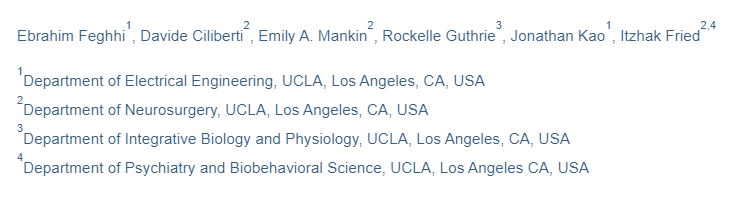
    
Conversation with Sophie:
- Look at resampling in MNE to deal with my bad graphs on the trials - it looks like mne calls this temporal decimation
- Follow the tutorials in MNE - preprocessing, filtering, and resampling data sections in particular, artifact detection
- Read about differencing - method for series resampling

Good article with a full run down of using MNE for their full project:
https://natmeg.se/mne_preprocessing/1-MNE_from_raw_to_epochs_evoked.html

Another good article I found - 0.1 Hz high pass and 40 Hz low pass. No magic to EEGnet they say. https://peijin.medium.com/deep-learning-for-eegs-nad-bci-some-notes-and-some-warnings-28cfc3015a98